In [48]:
!pip3 install pandas umap-learn matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# <font color='#3c3c3c'>Introduction</font>

text

# <font color='#3c3c3c'>EDA1: Pre Mood Column</font>

In [50]:
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

The first step we took was to find out some basic information about our dataset, such as the shape of the dataset, the names of the columns available, any missing values, and some general summary statistics. We also check for any duplicated values, to maintain a clean database. This way, we gain a general overview of the data we are working with.

Upon checking the shape and column names, as well as some summary stats, we observe:
- The dataset has 232725 rows and 18 columns.
- Most columns are numeric, which is preferred for ML models.
- There is only 1 missing value, track_name which has 232724 rows instead of 232725.
- key, mode, and time_signature are stored as 'object' type rather than numeric, so they will need to be converted into integers.
- Text columns, such as artist_name, track_name, and track_id, will most probably not be useful for predicting mood, and may be dropped in the future.
- Overall, the dataset seems clean and ready for preprocessing, with only some minor adjustments needed.

In [51]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (232725, 18)

Column Names:
 Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

The next step we took was to generate summary statistics for all of the numerical columns, in order to have a better idea of the feature scales, skewness, and any potential outliers that we should handle during preprocessing. Some key observations include:
1. Popularity:
    - The mean is 41.13, and the median is 43, indicating a roughly symmetric distribution.
    - The 25th percentile is 29, so most songs in this dataset are not very popular.
    - Std = 18.19, so a decent spread of popularity levels.
2. Acousticness:
    - Mean (0.369) > median (0.232), so it is a right skewed distribution
    - The 75th percentile is 0.722, meaning 75% of songs have acousticness below 0.722, This means most songs are not very acoustic.
    - The max val is close to 1, so some songs are fully acoustic. This reflects modern music trends, where most tracks are digitally produced.
    - Std = 0.355, showing high spread, so it is important for distinguishing acoustic/chill moods.
3. Danceability:
    - The mean (0.55) and median (0.57) are almost equal, suggesting a fairly symmetric distribution, so most songs are just moderately danceable.
    - This feature may help in differentiating between calm/chill (low danceability) or party/energetic (high danceability).
    - Std of 0.186, indicating moderate spread.
4. Duration:
    - The mean is 235000ms, so the average song lasts about 3.9 minutes.
    - The maximum song length is 5.5 million ms, which is around 92 minutes. This is an outlier we might have to deal with in the future.
    - The standard deviation is 118,936 ms, a very high spread mainly due to extreme outliers.
5. Energy:
    - Mean (0.57) < median (0.61), suggesting a slight left skew and a moderately energetic dataset.
    - Std = 0.263, implying a good spread and high predictive potential for energetic vs calm moods.
6. Instrumentalness:
    - Mean (0.15) > median (0.00004), so it is extremely right skewed.
    - 75% of songs < 0.036, so most songs contain vocals.
    - The standard deviation is 0.303, showing a high spread.
7. Liveness:
    - Max value of 1, meaning some live performances exist in the dataset.
    - Std of 0.198 indicates moderate spread, but weaker predictive power compared to other features.
8. Loudness:
    - A mean of -9.57dB, which is the spotify standard.
    - Min of -52dB, which could be silence or bad audio, and max of 3.74dB (unusually loud).
    - Std = 6 dB, so a very wide range of loudness levels, which could be important for capturing aggressive vs softer moods.
9. Speechiness:
    - Measures how much a track sounds like spoken words rather than musical singing.
    - Max of 0.97, may represent podcasts
    - Mean (0.12) > median (0.05), indicating high right skew (most songs are musical)
    - Std = 0.186, showing moderate spread.
10. Tempo:
    - Mean of 118 BPM matches most pop/rock music.
    - Wide range, (30-243) so most tracks are super slow/fast.
    - Std of 30.90 BPM, indicating high spread and good potential for predicting energetic vs calm moods.
11. Valence:
    - Positivity vs negativity. Mean (0.45) and median (0.44) are almost equal, indicating a centered distribution.
    - Std = 0.260, showing good spread across different emotional tones.
    - This may be very helpful for mood prediction, low valence may suggest sadness, and high happiness.

This statistical exploration allowed us to understand outliers, distributions, and spread of a feature. To better visualize the distributions of our features, we will actually plot the distributions in next steps.

In [53]:
df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

A formal check for missing values using .isnull and .sum allows us to confirm what we observed earlier, only one missing value which is in track_name.

In [54]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Then, we check for any duplicate rows in the dataset. Thankfully, there were no duplicate rows and so no further action was necessary.

In [55]:
df.duplicated().sum()

np.int64(0)

In [56]:
audio_features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'liveness', 'speechiness', 'instrumentalness', 'loudness']

Valence Distribution

The plot below shows the distribution of the valence feature. This feature measures how happy and cheerful a song sounds. These values range from 0.0 (very sad and negative) to 1.0 (very happy and positive). We can observe that there is a spike near 0.0, which means that there is a high number of sad songs (low valence songs). Aside from that, the distribution is fairly uniform between 0.1 until 0.8. This indicates that the majority of the songs span across a broad emotional range. We can also note that there is a noticeable drop at 1.0, meaning that there are few songs with a truly happy or upbeat emotional tone. In addition, the skewness of 0.14, indicates that distribution is nearly symmetric, with only a very slight right skew that indicates there are more high valence songs than low valence near the tail. The kurtosis of -1.01 also highlights that the valence values are well distributed, as it means that our distribution is flatter than normal with lighter tails (so values are evenly spread out).

This distribution also highlights a possible mood labeling strategy that would quantify the emotional positivity or negativity of a song depending on our scale from 0 to 1. Since we have yet to explore the rest of the features though, this remains just an initial proposal. 


In [57]:
from scipy.stats import skew, kurtosis

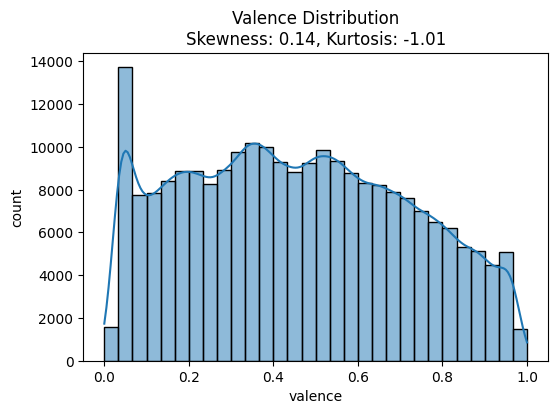

In [58]:
valence_skew = skew(df['valence'], nan_policy='omit')
valence_kurtosis = kurtosis(df['valence'], nan_policy='omit')

plt.figure(figsize=(6, 4))
sns.histplot(df['valence'], kde=True, bins=30)
plt.title(f'Valence Distribution\nSkewness: {valence_skew:.2f}, Kurtosis: {valence_kurtosis:.2f}')
plt.xlabel('valence')
plt.ylabel('count')
plt.show()

The energy distribution is slightly left-skewed, with the highest frequency of values around 10,000 and the lowest around 4,500. The skewness of -0.40 confirms this leftward skew, meaning there are more high-energy values than low-energy values. We also printed the kurtosis value to better understand the shape of the distribution, -0.81. Since it is less than 0 then this means that it has a flatter peak and less outliers (extreme valies) than a normal distribution, making the overall distribution more spread out.

In the context of our model's objective, understanding the distribution of the song's energy is probably a strong predictor for mood since high-energy songs tend to be "happy" while low-energy songs tend to be sad. Results show that most songs in the dataset are moderately to highly energetic, which suggests the model will be trained on a dataset biased toward more upbeat or intense moods. So, we need to keep an eye out to handle this during the training. Despite the imbalance, the feature appears to be useful and unlikely to mislead the model due to noise or outliers.

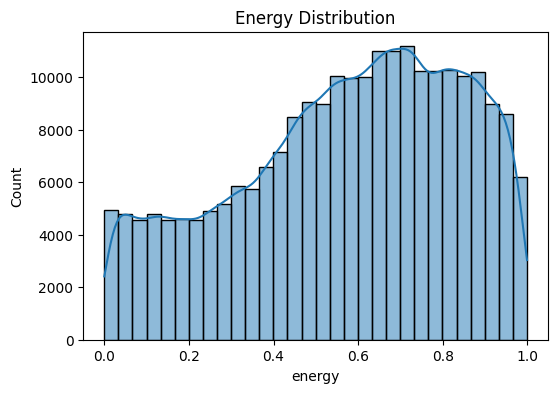

In [59]:
plt.figure(figsize=(6, 4))
sns.histplot(df['energy'], kde=True, bins=30)
plt.title('Energy Distribution')
plt.show()

In [60]:
print("Skewness:", df['energy'].skew())
print("Kurtosis:", df['energy'].kurt())

Skewness: -0.40022327921151274
Kurtosis: -0.8135949529345483


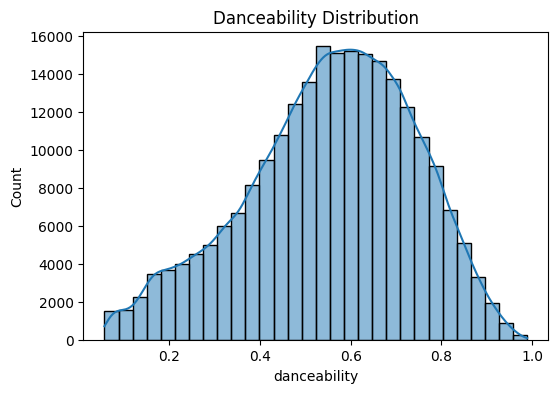

In [61]:
plt.figure(figsize=(6, 4))
sns.histplot(df['danceability'], kde=True, bins=30)
plt.title('Danceability Distribution')
plt.show()

We can see that most songs fall under the extremes with very few in the medium range(0.4-0.6) There is a huge spike on 0.0 meaning that they are likely electronic, synthetic, or heavy produced tracks. There is a smaller spike on 1.0 which means that these are acoustic, live recording etc. 

In what we saw in the stats table above we can see that this makes sense as the mean is 0.368 which means that it goes towards a lower acousticness

We can see that the skewness of the graph being 0.53, which is a positive skew, and it means that most songs have low acoustic content, with a long tail of high acoustic tracks.
The kurtosis being of -1.29 means that values are more evenly spread across the range with fewer extreme outliers

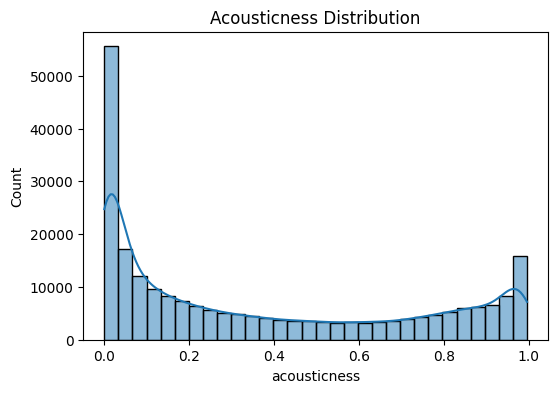

Skewness of acousticness: 0.53
Kurtosis of acousticness: -1.29


In [62]:
plt.figure(figsize=(6, 4))
sns.histplot(df['acousticness'], kde=True, bins=30)
plt.title('Acousticness Distribution')
plt.show()

acousticness_data = df['acousticness']

skewness = skew(acousticness_data)
kurt = kurtosis(acousticness_data)

print(f"Skewness of acousticness: {skewness:.2f}")
print(f"Kurtosis of acousticness: {kurt:.2f}")

The distribution of the tempo variable shows that most songs fall between the 90 and 130 bpm range. There's a clear peak around 100-110 bpm, which suggests that there is a presence of mid-tempo tracks maybe more chill and mainstream music. There is also a smaller bump around 120-130 bpm, meaning more energetic genres.

We can also see that tracks under 80 bpm are more uncommon, probably indicating sadder or mellow songs. On the other hand, we see a long tail of faster songs that go past 150 bpm. These might behave differently in mood prediction and could potentially act like outliers.

The skewness value of 0.403 indicates a mild right-skew. This confirms what we've discussed: basically that most songs are in the mid-tempo range, but there is a small group of faster tracks that extend the tail to the right. The kurtosis is -0.467, meaning the distribution is slightly flatter than a normal distribution. Tempo values are more spread out and less sharply peaked, but still fairly balanced and centered around a 90-130 bpm range. 

This plot helps us visualize and confirm what we see in the descriptive stats table above. With tempo values ranging from 30.38 bpm to 242.90 bpm, and having a mean of ~117.7 bpm and a median of ~115.8 BPM, we can assume tempo is slightly right-sweked. The spread, represented by std = 30.9, along with the kurtosis value suggest the dataset includes a good variety or tempo styles without extreme concetration in a specific range.

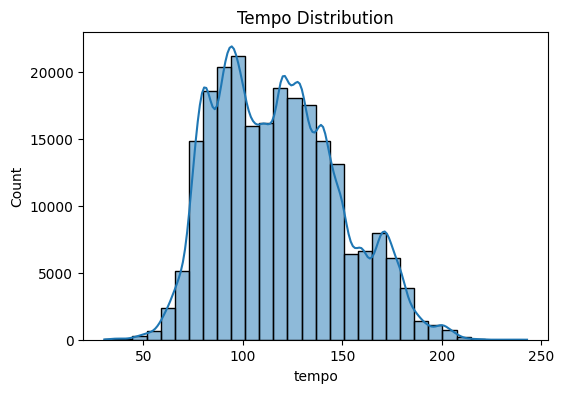

In [63]:
plt.figure(figsize=(6, 4))
sns.histplot(df['tempo'], kde=True, bins=30)
plt.title('Tempo Distribution')
plt.show()

Liveness Distribution

Liveness is measuring the prescence of a live audience or live performance characteristics in a track, going from 0.0 to 1.0.  
The graph shows a strong positive skew since most values have a liveness close to 0, meaning a majority of tracks are studio recorded, not live. This is reinforced with the skewness of 2.07 (which implies a strong positive skew). The kurtosis of 3.89 indicates a high peak around 0.1 and a heavier tail, meaning that few songs deviate strongly from the norm. Since this distribution is highly skewed, using it in the model without any type of scaling or transformation could hurt performance. This is something we will take into account in future steps. From this graph, we can also conclude that liveness is likely not particularly useful when detecting mood since most values are concentrated under 0.3. 

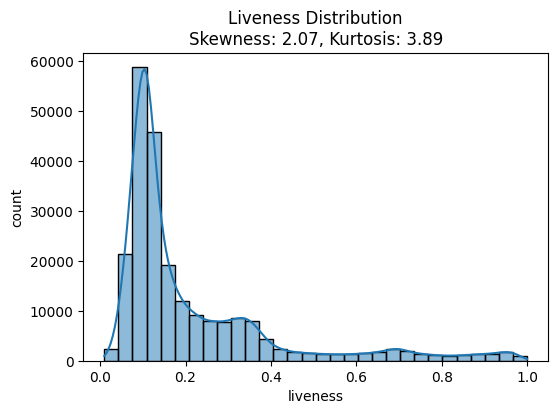

In [64]:
liveness_skew = skew(df['liveness'], nan_policy='omit')
liveness_kurt = kurtosis(df['liveness'], nan_policy='omit')

plt.figure(figsize=(6, 4))
sns.histplot(df['liveness'], kde=True, bins=30)
plt.title(f'Liveness Distribution\nSkewness: {liveness_skew:.2f}, Kurtosis: {liveness_kurt:.2f}')
plt.xlabel('liveness')
plt.ylabel('count')
plt.show()

We can see that higher values indicate more speech-like content (such as podcasts, rap, or voiceovers), and lower values represent typical musical tracks with singing. 

We can see that the graph is highly right-skewed (3.31), with most values being concentrated around 0.0 which means that most of the songs have minimal-speech content. This makes sense since most songs are sung rather than spoken dialogues, which is how spotify actually measures speechiness.

 
The kurtosis of 10.98 means that there is a highly peaked distribution, it means that while most songs cluster around low speechiness, there are notable outliers with significant higher values which likely corresponds to genres with high spoken content such as rap, etc.

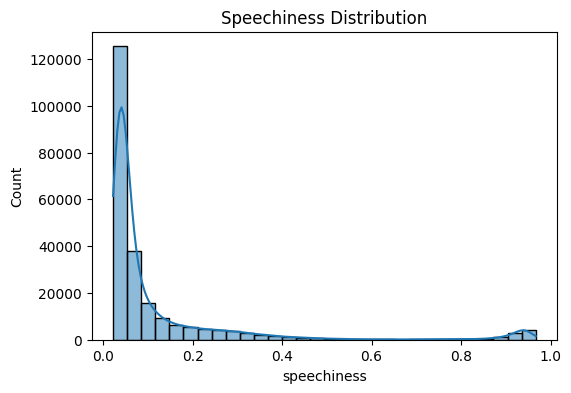

Skewness: 3.31
Kurtosis: 10.98


In [65]:
plt.figure(figsize=(6, 4))
sns.histplot(df['speechiness'], kde=True, bins=30)
plt.title('Speechiness Distribution')
plt.show()


speechiness_data = df['speechiness']
print(f"Skewness: {skew(speechiness_data):.2f}")
print(f"Kurtosis: {kurtosis(speechiness_data):.2f}")

The distribution of the instrumentalness feature is heavily right-skewed. It has a significant peak near 0, which indicates that most tracks in the dataset have vocals. There is also a very small cluster of tracks with instrumentalness close to 1.0. These represent instrumental-only songs. These take up a small portion of the dataset, but they're still important because they may behave differently in mood modeling.

The instrumentalness distribution shows a strong right-skew, confirmed by a skewness of 1.820, meaning most tracks have very low instrumentalness.

The kurtosis is 1.588, indicating a distribution that is more peaked than normal, with heavy tails. This means while most songs cluster near zero, there’s a distinct minority of fully instrumental tracks that stand out at the upper end of the scale.

Lastly, the instrumentalness feature has a mean of ~0.15 and a median of 0.0, indicating that over half the tracks have no instrumental quality, in other words they contain vocals. The minimum, 25th, and 50th percentiles are all exactly 0.0, which show that the majority of tracks fall at the very bottom of the scale. However, the maximum value reaches 0.999, showing that some tracks are fully instrumental.

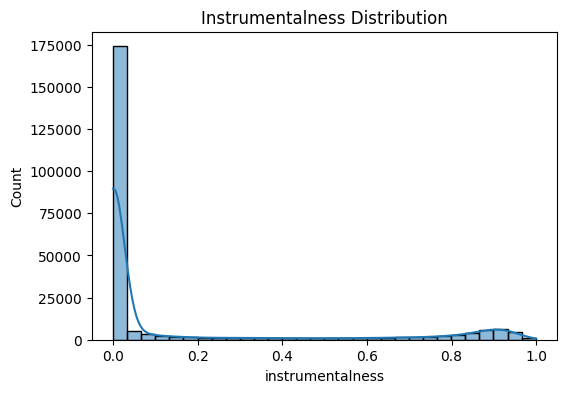

Instrumentalness Skewness: 1.820
Instrumentalness Kurtosis: 1.588


In [66]:
plt.figure(figsize=(6, 4))
sns.histplot(df['instrumentalness'], kde=True, bins=30)
plt.title('Instrumentalness Distribution')
plt.show()

inst_data = df['instrumentalness'].dropna()

inst_skew = skew(inst_data)
inst_kurt = kurtosis(inst_data)  

print(f"Instrumentalness Skewness: {inst_skew:.3f}")
print(f"Instrumentalness Kurtosis: {inst_kurt:.3f}")

The loudness feature in the dataset has values ranging from -52.46 dB to 3.74 dB, with a mean of -9.57 dB and a median of -7.76 dB. This means most tracks are fairly loud, represented by those close to 0 dB, while only a small minority are significantly quieter.

The distribution is left-skewed, the skewness being -1.662, which is clearly visible in the histogram. There’s a long tail of very quiet tracks pulling the distribution to the left.

The kurtosis is 3.207, indicating that the distribution is sharply peaked with heavy tails. This suggests that most tracks are clustered tightly around typical loudness values ( -10 to -5 dB), but there are outliers at both extremes (super loud and super soft).

To conclude, this means loudness is a solid feature for modeling the intensity of a track. Louder songs may correlate with high-energy or party moods, while quieter tracks could lean more toward chill, acoustic, or emotional vibes. This will all help in mood predicting.

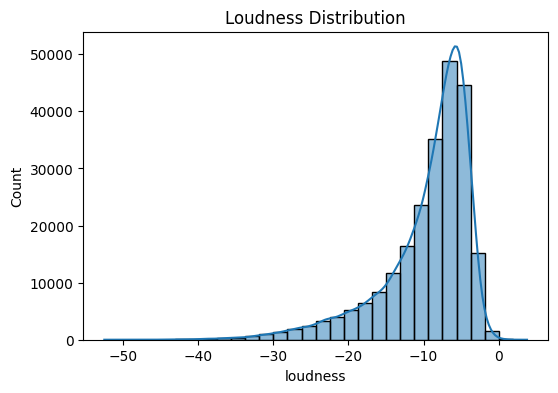

Loudness Skewness: -1.662
Loudness Kurtosis: 3.207


In [67]:
plt.figure(figsize=(6, 4))
sns.histplot(df['loudness'], kde=True, bins=30)
plt.title('Loudness Distribution')
plt.show()

loud_data = df['loudness'].dropna()

loud_skew = skew(loud_data)
loud_kurt = kurtosis(loud_data)  

print(f"Loudness Skewness: {loud_skew:.3f}")
print(f"Loudness Kurtosis: {loud_kurt:.3f}")

Now, to further analyze the relationship between the features, we have decided to print a correlation map since it's the easiest to visualize. If we consider those positive or negatives values greater than 0.6, then the graph shows three strong correlations. 
- **loudness vs acousticness (-0.69)**: This means that as the loudness of a track increases (strong negative correlation), the acousticness tends to decrease, and vice versa. In the context our model, this helps us better understand how "intense" or "natural" a song is. We could potentially remove one to decrease the number of features, but we beleive both are revelant since they describe different things.

- **energy vs acousticness (-0.73)**: This means that as the energy increases the acousticness decreases (strong negative correlation). Which makes sense since high-energy music often involves more synthesized or amplified sounds, whereas acoustic music tends to be calmer, with less energy.  This relationship reinforces the idea that energy could be an important feature for predicting moods like excited, angry, or happy, while acousticness might be more relevant for moods like calm or sad. Additionally, this is similar to the previous relationship, where we are not sure we should remove one or the other becuase both feature describe different things and can help predict different moods that are similar to just "happy" or "sad".

- **energy vs loudness (0.82)**: This means that as energy increases, so does the loudness (strong postive correlation). This is expected, as more intense and energetic music often has higher volumes and more dynamic sound. Since these features are more related to each other in terms of what they describe, typically upbeat, excited, or happy moods, maybe it we could drop one. 

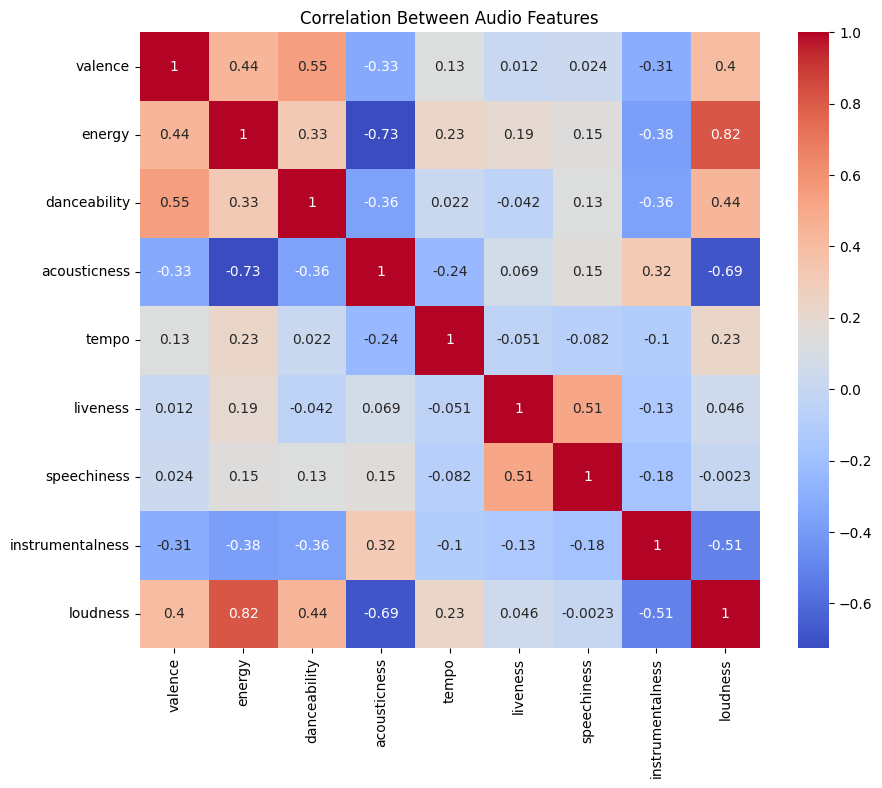

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Audio Features')
plt.show()

The first bar plot shows the top genres in the dataset, with each bar representing the number of tracks per genre. We can see that within these genres, there are roughly an equal amount of songs (nearly 1000)


The valence feature captures the musical positivity or emotional brightness of a song, where values closer to 1.0 indicate a happy, cheerful, or euphoric tone, and values near 0.0 suggest sadness, melancholy, or tension.

Analyzing valence across all genres in the dataset reveals distinct emotional profiles:
- Genres such as Pop, Reggae, Ska, Jazz, and Comedy show high median valence, indicating that these styles tend to produce more uplifting or feel-good tracks, consistent with their energetic or playful musical characteristics.

- Hip-Hop, Dance, Country, and Electronic display moderate valence levels, reflecting a mix of emotional tones depending on lyrical content and production style.

- On the lower end, Soundtrack, Opera, and Classical genres have notably lower median valence, with many tracks clustering near 0.2 or below. This suggests these genres are often composed to evoke more emotional depth, tension, or introspection.

- Interestingly, Children’s Music shows a bimodal distribution, with both very high and very low valence songs, likely due to its diversity between upbeat singalongs and calm lullabies.

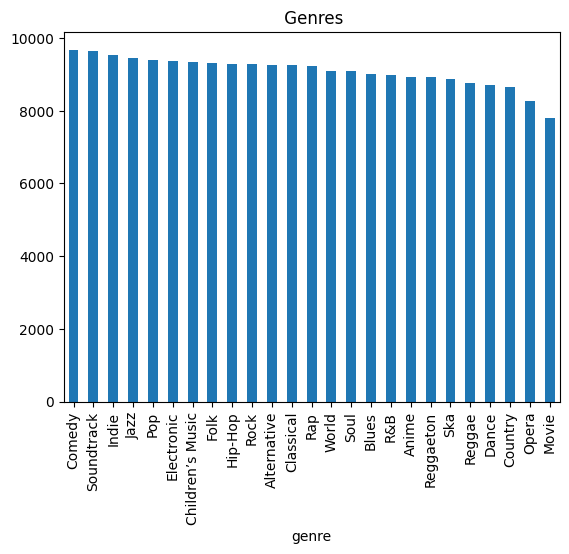

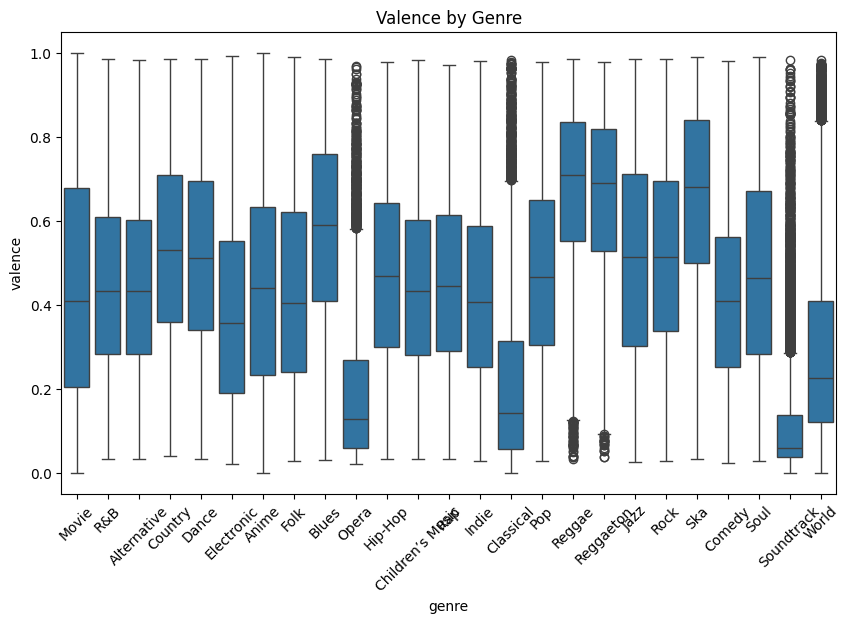

In [69]:
df['genre'].value_counts().head(25).plot(kind='bar')
plt.title(' Genres')
plt.show()

top_genres = df['genre'].value_counts().head(25).index
subset = df[df['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='valence', data=subset)
plt.title('Valence by Genre')
plt.xticks(rotation=45)
plt.show()

The next step we decided to conduct was a formal outlier check using boxplots, to better visualize and confirm the analysis discussed earlier. Outlier detection is focused on the numeric features, as categorical outliers are not exactly outliers, just rare.

From the plots, we can observe:
- valence, energy, and danceability are normalized between 0 and 1, and contain minimal/no outliers
- tempo has some high end outliers, with BMP above 200, indicating there are some songs that are faster than the average song.
- acousticness does not have formal outliers, however it is heavily right skewed.
- duration contains extreme outliers, with some tracks lasting millions of seconds (over an hour). These may represent podcasts for example.

Most mood related features, such as valence, energy, and danceability are fairly consistent. Temp and acousticness show some variability, but this may be useful for finding distinct mood clusters. If kept, duration includes extreme values that may need to be dealt with if they are just noise before any model training.

Using IQR, we also counted the extreme outliers, and observed tempo has 168 extreme outliers, and duration 14651. Our plan for now is to keep tempo but scale it appropriately, and if used remove extreme values from duration.

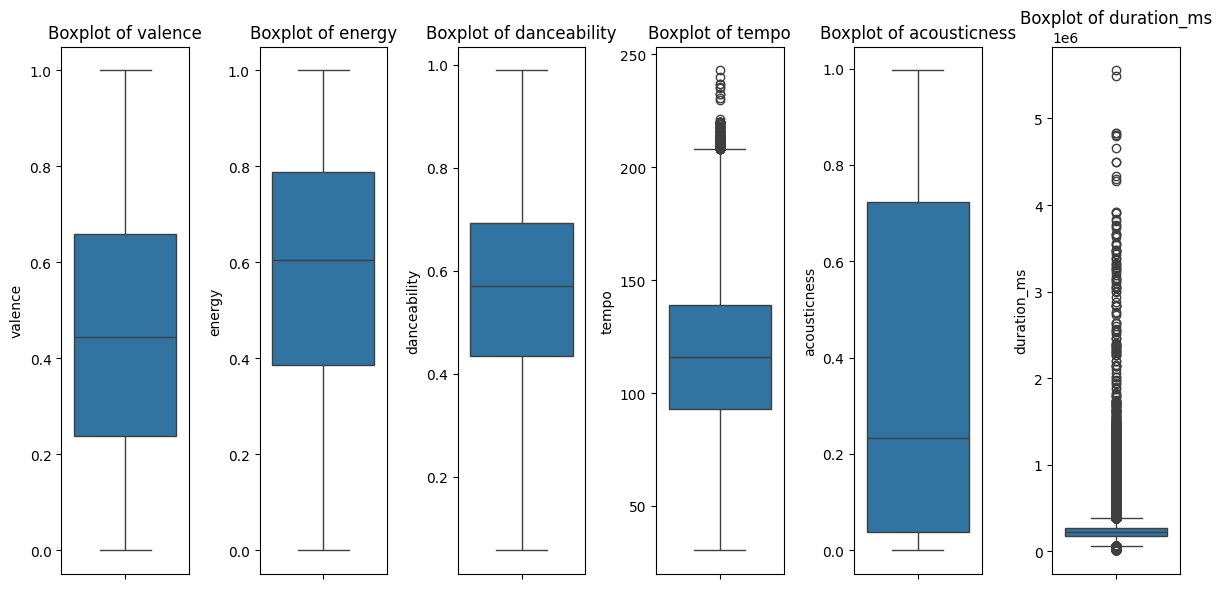

valence: 0 outliers
energy: 0 outliers
danceability: 0 outliers
tempo: 168 outliers
acousticness: 0 outliers
duration_ms: 14651 outliers


In [70]:
numeric_features = ['valence', 'energy', 'danceability', 'tempo', 'acousticness', 'duration_ms']

plt.figure(figsize=(12, 6))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers")

Since we observed extreme outliers in duration, we hypothesized earlier that they may be podcasts. To better understand our outliers, we sorted the dataset by duration in descending order and examined the top entries.

Many tracks were around 70-90 minutes long, such as:
- Episode 15 and episode 14, which must be a podcast
- 6:00 AM, which seems to be a continuous mix of music
- Lost Lands 2017 mix, which seems to be a DJ mix
- Nature Sounds for Sleep, which is a sleep audio

These are clearly not standard songs, and they may bias the model as their unusually long durations do not reflect the average song. In the end, we will most probably exclude tracks longer than 15 minutes to reflect real world song lengths and maintain consistency so that real music is the main focus.

In [71]:
long_tracks = df.sort_values(by='duration_ms', ascending=False)

long_tracks[['track_name', 'artist_name', 'duration_ms', 'genre']]
long_tracks['duration_min'] = long_tracks['duration_ms'] / 60000
long_tracks[['track_name', 'artist_name', 'duration_min', 'genre']].head(5)

track_name      artist_name  \
212083  Episodio 15 (Lady Orinoco, Políticas De Youtub...   La Mesa Reñoña   
162671                                          6 : 00 Am         DJ Luigi   
23593                                 Lost Lands 2017 Mix         Excision   
211969       Episodio 14 (Machismo, Juanga, Bebé a Bordo)   La Mesa Reñoña   
219057  Nature Sounds for Sleep: Crackling Log Fire wi...  Jamie Llewellyn   

        duration_min       genre  
212083     92.548617      Comedy  
162671     91.466667   Reggaeton  
23593      80.510100  Electronic  
211969     80.509733      Comedy  
219057     80.066917       World

Our initial exploratory data analysis focused on gaining a foundational understanding of the Spotify dataset before applying any mood labeling. Key findings include:

Dataset Structure:
The dataset contains 232725 tracks and 18 columns, most of which are numerical audio features suitable for machine learning.
- A few non-numerical columns (track_name, artist_name, track_id) were identified as irrelevant for modeling and will be excluded.

Feature Quality
- Missing values were nearly non-existent, with only 1 missing entry in track_name.
- All mood-related features are numerical and normalized or easily scaled.
- Data types for key, mode, and time_signature were noted for possible conversion.

Distribution and Correlation
- Distribution plots showed that core features look good, with slight skew in acousticness and tempo.
- A correlation heatmap confirmed strong internal structure:
  - Energy and loudness are highly correlated (as expected).
  - Valence, danceability, and energy show useful, but not redundant, overlap.

Outlier Detection using boxplots and IQR:
  - Valence, energy, danceability, and acousticness had no extreme outliers.
  - Tempo showed 168 fast-paced outliers, likely representing high-BPM music.
  - Duration_ms had over 14,000 extreme outliers, with durations often exceeding 1 hour.
- Manual inspection of top-duration tracks revealed non-music content (podcasts, ambient soundtracks, comedy specials).


In conclusion, the dataset is clean, and structured. Core features behave predictably and show interpretable relationships. We are now ready to proceed to K-Means clustering to generate mood labels.

# <font color='#3c3c3c'>Creating Mood Clusters</font>

During our second part of data exploration, we realized that the dataset included 9681 tracks labeled under the “Comedy” genre. When we actually listened, these entries were not your typical songs but more spoken-words type of content, for example stand-up comedies or skits.	This makes them irrelevant for mood prediction.

To confirm this, we compared key audio features between comedy and non-comedy tracks using boxplots:
- Instrumentalness: Comedy tracks had almost zero instrumentalness, reflecting their wordy nature.
- Acousticness: Comedy entries showed consistently high acousticness, also suggesting they’re more based on speech.
- Valence: Less extreme values, but still comedy tracks tended toward lower valence scores, suggesting a more neutral tone.
- Energy: Slightly elevated energy on average and also included low-end outliers maybe because of inconsistent recording styles of comedy.

Including these tracks in our model analysis posted two main issues:
- They don’t convey musical mood in the same way songs do. This confused our model during mood prediction.
- As shown in the comparison boxplots, their values for audio features like valence, energy, acousticness, and instrumentalness don’t reflect typical musical structure and could add noise. 

As a result, we dropped all Comedy entries from the dataset.

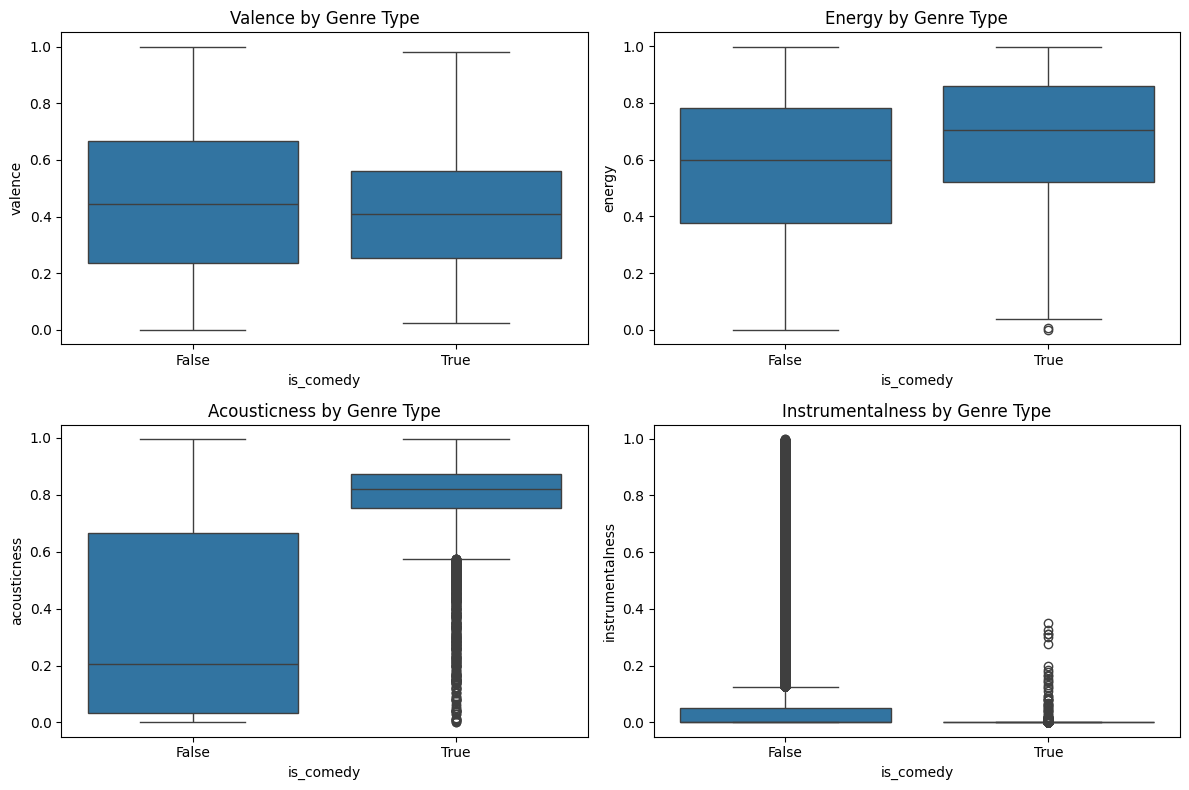

In [72]:
df['is_comedy'] = df['genre'] == 'Comedy'

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

features = ['valence', 'energy', 'acousticness', 'instrumentalness']
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=df, x='is_comedy', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature.capitalize()} by Genre Type')

plt.tight_layout()
plt.show()

In [73]:
df.drop(columns='is_comedy', inplace=True)

In [74]:
print("Number of 'comedy' entries:", df[df['genre'] == 'Comedy'].shape[0])

Number of 'comedy' entries: 9681


In [75]:
df = df[df['genre'] != 'Comedy']

In [76]:
print("'comedy' entries remaining:", (df['genre'] == 'comedy').sum())

'comedy' entries remaining: 0


To avoid any risk of data leakage during this step, we worked with a copy of the original dataframe, named df_cluster, instead of modifying the original data directly. This way, all clustering logic is isolated and won’t affect downstream supervised learning unless explicitly added back. 
We picked a reduced set of features for clustering:
- Valence, energy, and acousticness.

We chose these based on intuition and EDA given that they’re conceptually tied to mood. Using a small number of core features reduces noise and helps interpret clusters.

We scaled these features using StandardScaler to ensure that K-Means wouldn't be biased by differences in scale, since K-Means is distance-based and unscaled values would distort the clustering.

Then, we trained the model with K=5 clusters using KMeans(n_clusters=5, random_state=42). We used 5 to allow a range of moods without breaking up the data too much.

The cluster assignments were stored in a new column called mood_cluster, and for convenience, we mapped the cluster numbers to string labels (Cluster 1, Cluster 2, …) as a placeholder. These can later be renamed to the actual mood labels like "Happy", "Sad", etc. We did this because it didn’t make sense to label the clusters directly with the moods because we didn’t know how K-means was gonna group them. We just wanted to listen to a few of the songs in each cluster to then identify what each of them represented.

Lastly, we copied these mood labels back into the original dataset under the column mood. This was the only point at which the original dataframe was modified with K-Means results; everything else was done separately in df_cluster.

Doing this before splitting the dataset is important because we’re using unsupervised learning to create labels. Also, no outcome variable is being predicted yet. Following this order, we made sure there’s no risk of data leakage.

In [77]:
df_cluster = df.copy()

# the three features we decided to cluster by 
clustering_features = ['valence', 'energy', 'acousticness']
X_cluster = df_cluster[clustering_features]

# just in case, we're creating a variable with the remaining numerical features 
full_features = [
     'danceability', 'tempo',
    'loudness', 'speechiness', 'instrumentalness', 'liveness'
]
X_full = df[full_features]

In [78]:
from sklearn.preprocessing import StandardScaler

cluster_scaler = StandardScaler()
X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

In [79]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster['mood_cluster'] = kmeans.fit_predict(X_cluster_scaled)

# we can't use proper labels yet since we don't know what they represent 
cluster_to_mood = {
    0: 'Cluster 1',
    1: 'Cluster 2',
    2: 'Cluster 3',
    3: 'Cluster 4',
    4: 'Cluster 5'
}
df_cluster['mood'] = df_cluster['mood_cluster'].map(cluster_to_mood)  

In [80]:
df['mood'] = df_cluster['mood']

In [81]:
df['mood'].nunique()

5

In [82]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_cluster_scaled)

df_cluster['pca1'] = components[:, 0]
df_cluster['pca2'] = components[:, 1]

fig = px.scatter(
    df_cluster,
    x='pca1',
    y='pca2',
    color='mood',
    title='Mood Clusters of Songs (PCA)',
    labels={'pca1': 'Principal Component 1', 'pca2': 'Principal Component 2'},
    hover_data=['mood_cluster']
)

fig.update_layout(
    width=800,
    height=600,
    legend_title_text='Mood'
)

fig.show()

In [83]:
## CREATED BY CHATGPT ##

def plot_kmeans_clusters(X_scaled, k, feature_df, color_list=None):
    """
    Fits KMeans and PCA, and plots scatter plot of clusters using matplotlib.

    Parameters:
        X_scaled (np.array): Scaled features for clustering
        k (int): Number of clusters
        feature_df (pd.DataFrame): Original dataframe to copy for plotting
        color_list (list): Optional list of fixed colors (hex or named)
    """

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    # Build DataFrame for plotting
    plot_df = feature_df.copy().reset_index(drop=True)
    plot_df['mood_cluster'] = clusters
    plot_df['pca1'] = components[:, 0]
    plot_df['pca2'] = components[:, 1]

    # Default color palette if not provided
    if color_list is None:
        color_list = plt.get_cmap('Set2').colors  # 10 visually distinct colors

    # Ensure color_list has enough colors
    if k > len(color_list):
        raise ValueError(f"Color list must contain at least {k} colors.")

    # Assign colors to clusters
    cluster_colors = [color_list[i] for i in clusters]

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        plot_df['pca1'], plot_df['pca2'],
        c=cluster_colors,
        alpha=0.75,
        s=100
    )


    # Create legend
    legend_labels = [f"Cluster {i}" for i in range(k)]
    handles = [plt.Line2D(
        [0], [0], marker='o', color='w',
        label=legend_labels[i],
        markerfacecolor=color_list[i],
        markeredgecolor='black',
        markersize=10
    ) for i in range(k)]

    plt.legend(handles=handles, title="Cluster", frameon=True, fancybox=True)
    plt.title(f'Mood Clusters (k={k}) - PCA Projection', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

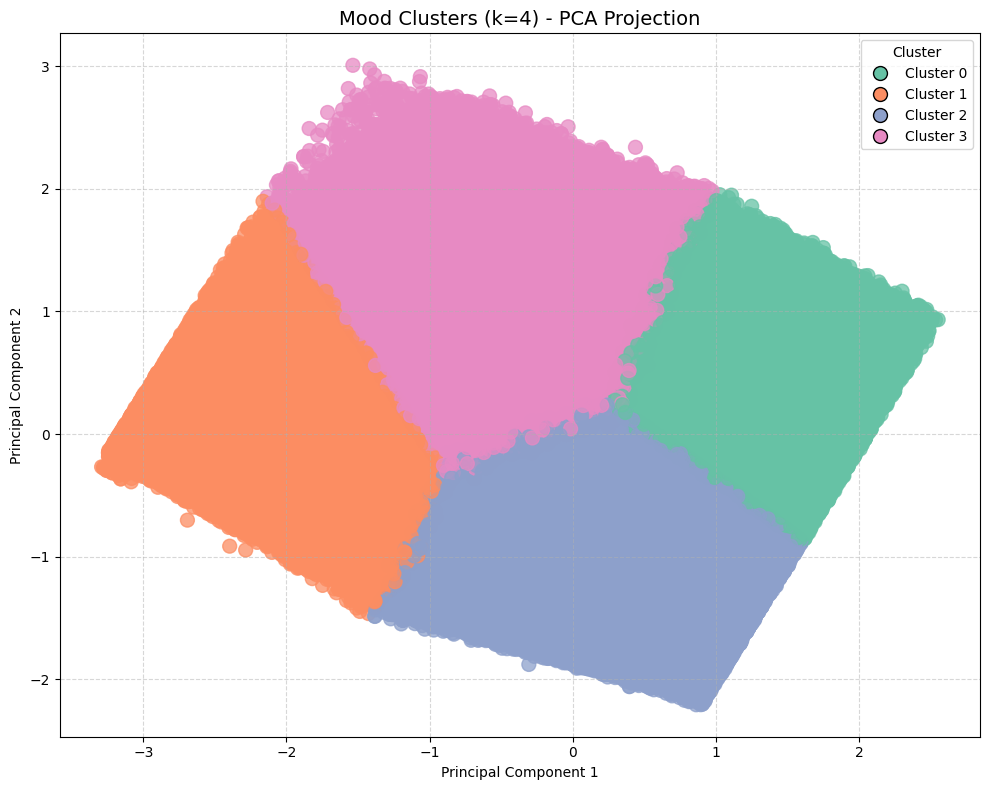

In [84]:
plot_kmeans_clusters(X_cluster_scaled, 4, df_cluster)

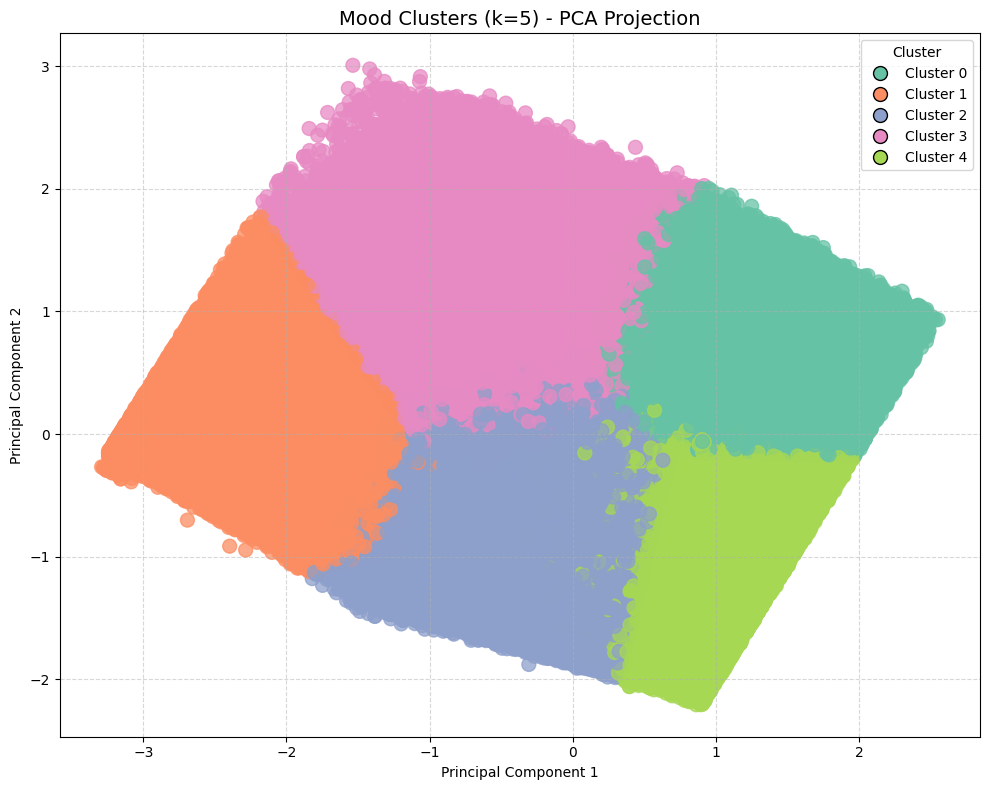

In [85]:
plot_kmeans_clusters(X_cluster_scaled, 5, df_cluster)

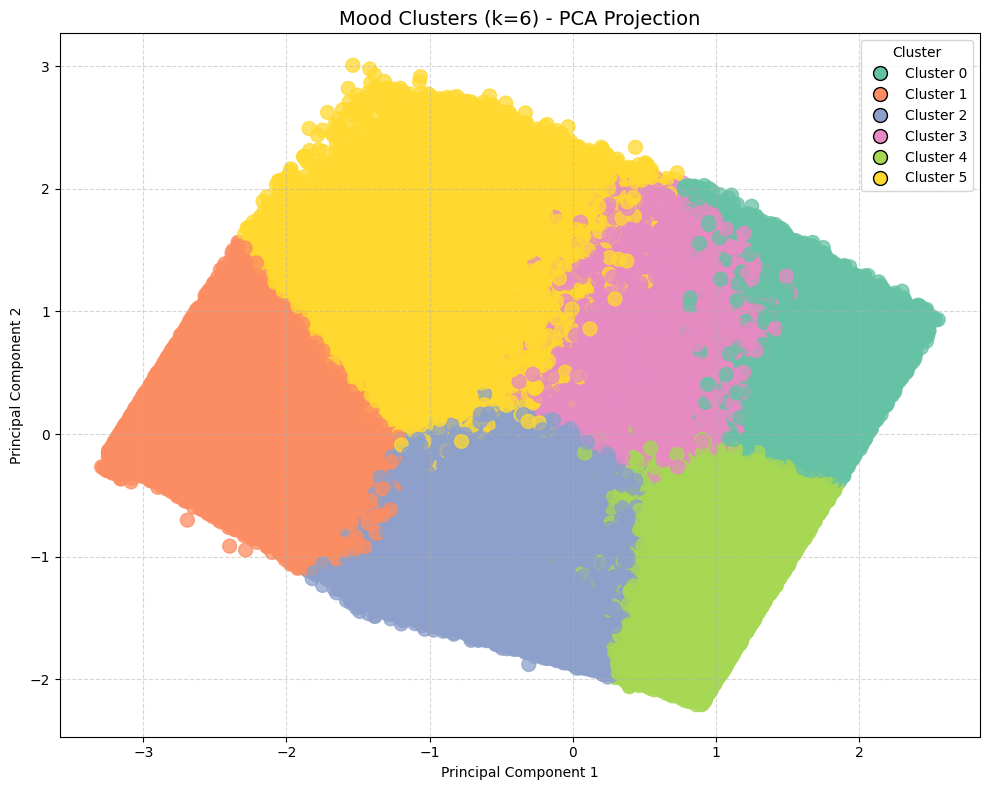

In [86]:
plot_kmeans_clusters(X_cluster_scaled, 6, df_cluster)

In [87]:
cluster_summary = df_cluster.groupby('mood_cluster')[clustering_features].mean()
print(cluster_summary)

               valence    energy  acousticness
mood_cluster                                  
0             0.758946  0.741482      0.134775
1             0.173639  0.184282      0.877450
2             0.274675  0.513595      0.219184
3             0.639244  0.442294      0.671929
4             0.401377  0.821940      0.060605


# <font color='#3c3c3c'>EDA2: Post Mood Column</font>

In [88]:
# Randomly printing 10 songs from each cluster 
for cluster_id in range(5):
    print(f"\nCluster {cluster_id}")
    display(
        df_cluster[df_cluster['mood_cluster'] == cluster_id][
            ['track_name', 'artist_name', 'genre','valence', 'energy', 'acousticness']
        ].sample(10, random_state=42)
    )


Cluster 0


track_name       artist_name  \
91351                                        Bébé               MHD   
75904                                 6 In 2 Days  Music with Brian   
177286                               We Can Do It        Jamiroquai   
215381                           More Than I Know      Jordan Davis   
56625                                     Lil Bit            K CAMP   
25881                             A Different Way          DJ Snake   
192683  You're The First, The Last, My Everything       Barry White   
188510              Honour Your Mother and Father    Desmond Dekker   
93844                                       Heavy            POWERS   
18523                                     Elevate     Big Time Rush   

                   genre  valence  energy  acousticness  
91351            Hip-Hop    0.839   0.672       0.16200  
75904   Children's Music    0.749   0.893       0.00156  
177286              Jazz    0.911   0.776       0.00434  
215381           Country    0.654   0.917       0.02790  
56625                R&B    0.698   0.634       0.43900  
25881         Electronic    0.580   0.752       0.48800  
192683              Soul    0.927   0.590       0.00367  
188510               Ska    0.856   0.573       0.07820  
93844              Indie    0.856   0.686       0.00665  
18523              Dance    0.622   0.860       0.02800


Cluster 1


track_name  \
493                                       Marty And Henry   
43060                                     Ultralight Beam   
80430                                Act II: Vissi d'arte   
129466                                               Bifu   
104102  Concerto No. 2 in E-Flat Major, K.417: III. Ro...   
202075                                   Work The Problem   
203736                                               Pink   
98512                              Other Side Of The Game   
211137                 Daydream (feat. Ashwin Srinivasan)   
167172                                      Like An Angel   

                         artist_name             genre  valence  energy  \
493                     Randy Newman             Movie   0.0382  0.0317   
43060                  Local Natives              Folk   0.2000  0.0975   
80430                Giacomo Puccini             Opera   0.0589  0.2160   
129466                   Somei Satoh         Classical   0.0268  0.0390   
104102       Wolfgang Amadeus Mozart         Classical   0.4950  0.0738   
202075        Harry Gregson-Williams        Soundtrack   0.0647  0.1450   
203736  David Arnold & Michael Price        Soundtrack   0.0766  0.0617   
98512                    Erykah Badu  Children’s Music   0.1970  0.2620   
211137                 Nitin Sawhney             World   0.4590  0.1480   
167172          Anne Sofie von Otter         Classical   0.1210  0.0831   

        acousticness  
493            0.987  
43060          0.939  
80430          0.991  
129466         0.979  
104102         0.992  
202075         0.623  
203736         0.911  
98512          0.486  
211137         0.974  
167172         0.966


Cluster 2


track_name            artist_name  \
121020                         Southern Hospitality             Jelly Roll   
213632                             Son of the South               Upchurch   
146662                                       Lately            Anita Baker   
115583                                     Like Dat            Kodak Black   
209838                      The Pure and the Damned  Oneohtrix Point Never   
155405                                  Alyssa Lies  Jason Michael Carroll   
19324                Getting Over You - R3HAB Remix                   Lauv   
6056    Isn't He (This Jesus) [feat. Natalie Grant]          Natalie Grant   
86146                                        If You                   Silk   
119683    A Spike Lee Joint (feat. Anthony Flammia)       Flatbush Zombies   

              genre  valence  energy  acousticness  
121020          Rap   0.3900   0.606        0.1000  
213632      Country   0.1360   0.706        0.0130  
146662         Jazz   0.2680   0.544        0.4120  
115583          Rap   0.4820   0.476        0.0291  
209838        World   0.0394   0.191        0.3590  
155405         Rock   0.4140   0.597        0.3090  
19324         Dance   0.1180   0.646        0.0310  
6056    Alternative   0.0622   0.467        0.1180  
86146           R&B   0.3360   0.477        0.1840  
119683          Rap   0.4840   0.511        0.1390


Cluster 3


track_name             artist_name  \
146544                           L-O-V-E          Gregory Porter   
150272                              Gold               Sam Feldt   
194734  Emilie Jolie & le conteur, Pt. 2          Henri Salvador   
138075                      Don't Dis Me             Vybz Kartel   
110879                       Save Myself              Ed Sheeran   
118297                              Stay             Iamjakehill   
73845          The House That Jack Built  Kimbo Children's Music   
231576                         Moon Dogs                   SALES   
180638               Mr. Broadway - Live            Dave Brubeck   
205670          Morning On Boston Common           Randy Edelman   

                   genre  valence  energy  acousticness  
146544              Jazz    0.531   0.279         0.697  
150272               Pop    0.539   0.703         0.539  
194734             Movie    0.788   0.424         0.339  
138075            Reggae    0.855   0.474         0.464  
110879               Pop    0.481   0.290         0.850  
118297               Rap    0.857   0.668         0.811  
73845   Children's Music    0.672   0.239         0.705  
231576              Soul    0.580   0.363         0.761  
180638              Jazz    0.561   0.399         0.319  
205670        Soundtrack    0.589   0.395         0.963


Cluster 4


track_name         artist_name  \
49869                            Bad Blood   Black Pistol Fire   
89392                       Window Shopper             50 Cent   
121431                              Ashley            Big Sean   
84501               Don't Be Gone Too Long         Chris Brown   
99564             The Hangman's Body Count             Volbeat   
1851                               Our God        Chris Tomlin   
11979                        Restless Year         Ezra Furman   
154231  Will The Circle Be Unbroken - Live       Warren Haynes   
3241                                   You           Candlebox   
147403                      Tooth and Claw  Animals As Leaders   

                   genre  valence  energy  acousticness  
49869              Blues    0.355   0.820      0.017300  
89392            Hip-Hop    0.467   0.628      0.107000  
121431               Rap    0.433   0.910      0.091900  
84501                R&B    0.435   0.791      0.258000  
99564   Children’s Music    0.284   0.948      0.000059  
1851         Alternative    0.216   0.778      0.009980  
11979        Alternative    0.489   0.947      0.031100  
154231              Rock    0.293   0.745      0.186000  
3241         Alternative    0.599   0.861      0.007890  
147403              Jazz    0.253   0.967      0.000546

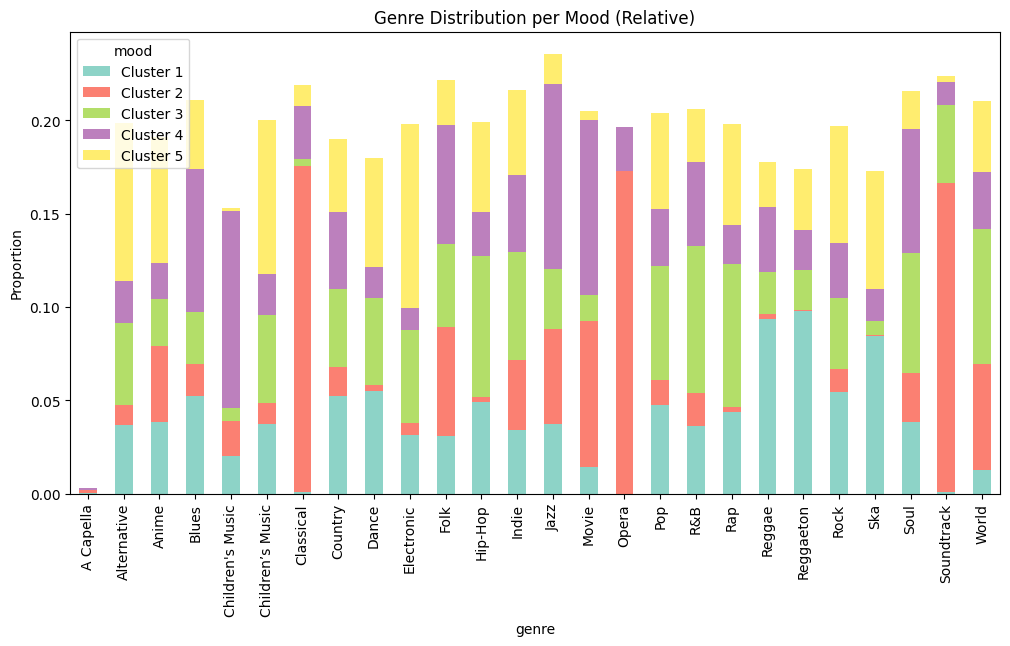

In [89]:
## CREATED WITH CHATGPT ##

genre_mood_ct = pd.crosstab(df['mood'], df['genre'])
genre_mood_ct = genre_mood_ct.div(genre_mood_ct.sum(axis=1), axis=0)

genre_mood_ct.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title("Genre Distribution per Mood (Relative)")
plt.ylabel("Proportion")
plt.show()

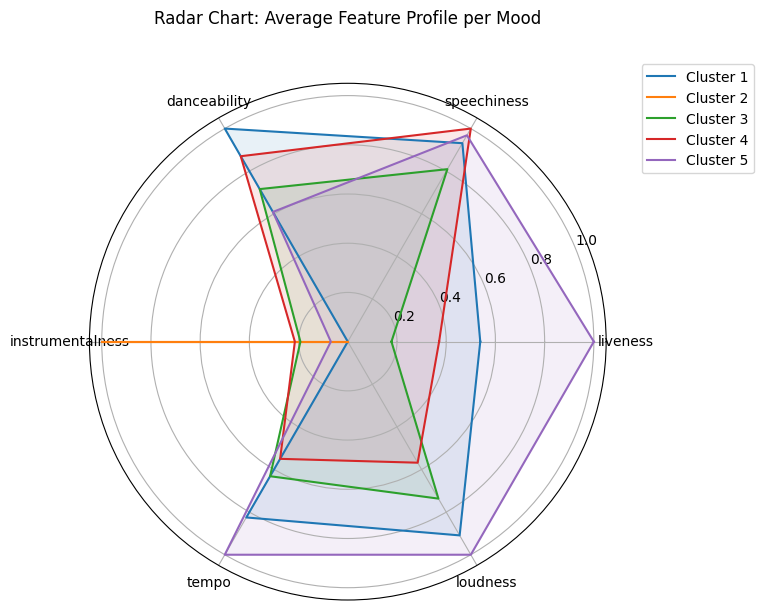

In [90]:
## CREATED WITH CHATGPT ##

# all numerical features (except the ones we sued for clustering)
radar_features = ['liveness', 'speechiness', 'danceability', 'instrumentalness', 'tempo', 'loudness']

# Compute mean of each feature per mood
radar_data = df.groupby('mood')[radar_features].mean()

# Normalize features for better comparison (0–1 scale)
radar_data_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())
# Number of features
labels = radar_features
num_vars = len(labels)

# Angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop
# Create plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each mood
for mood in radar_data_norm.index:
    values = radar_data_norm.loc[mood].tolist()
    values += values[:1]  # close the polygon
    ax.plot(angles, values, label=mood)
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Radar Chart: Average Feature Profile per Mood", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05))
plt.tight_layout()
plt.show()

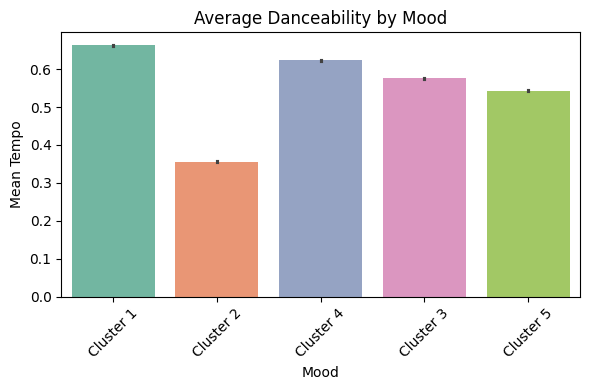

In [91]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='danceability', hue='mood', palette='Set2', legend=False)
plt.title('Average Danceability by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

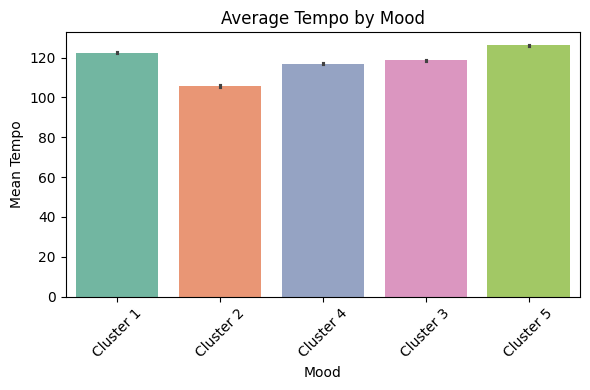

In [92]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='tempo', hue='mood', palette='Set2', legend=False)
plt.title('Average Tempo by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

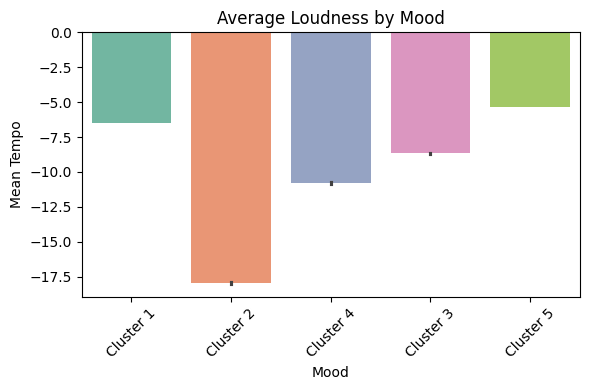

In [93]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='loudness', hue='mood', palette='Set2', legend=False)
plt.title('Average Loudness by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

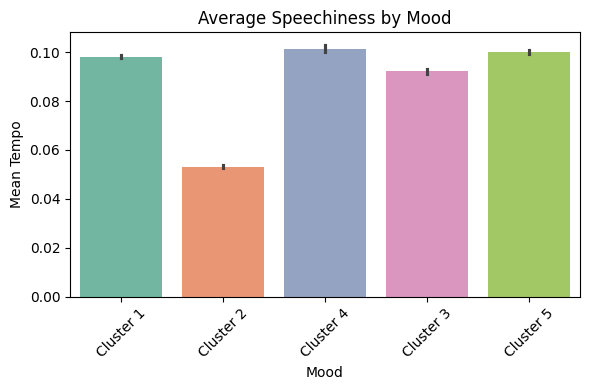

In [94]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='speechiness', hue='mood', palette='Set2', legend=False)
plt.title('Average Speechiness by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

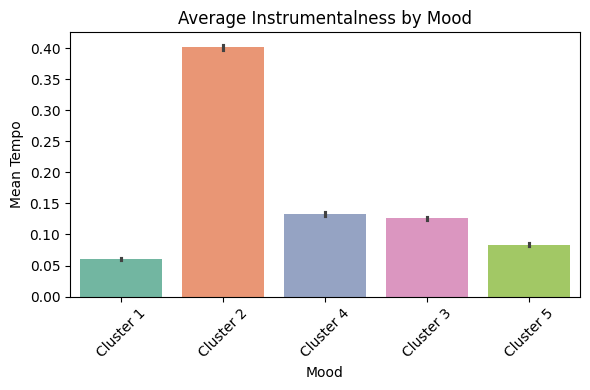

In [95]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='instrumentalness', hue='mood', palette='Set2', legend=False)
plt.title('Average Instrumentalness by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

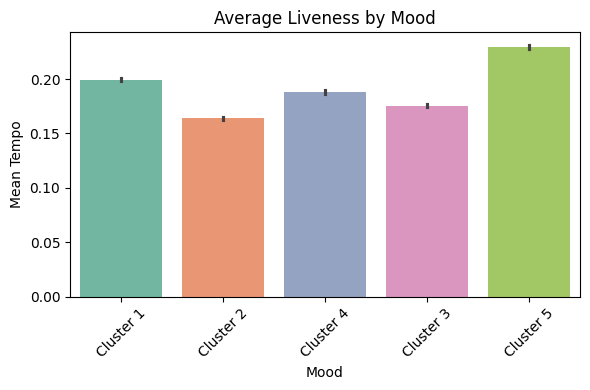

In [96]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='mood', y='liveness', hue='mood', palette='Set2', legend=False)
plt.title('Average Liveness by Mood')
plt.xlabel('Mood')
plt.ylabel('Mean Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

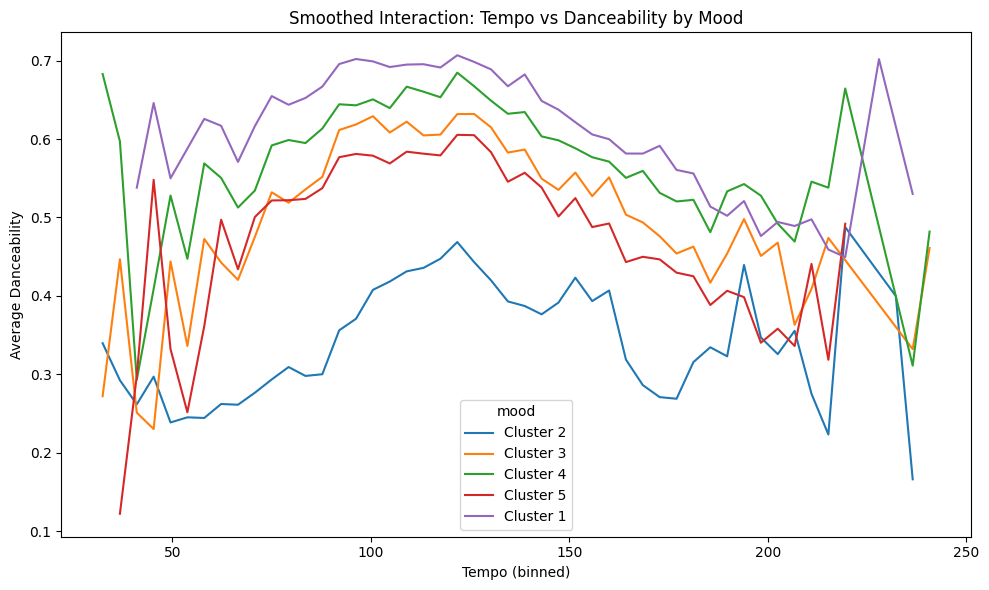

Slopes (tempo vs danceability) by mood:
Cluster 1: -0.0012
Cluster 2: 0.0010
Cluster 3: -0.0003
Cluster 4: -0.0005
Cluster 5: -0.0013


In [97]:
## CREATED WITH CHATGPT ##

## BAD INTERACTION, JUST GOOD EXAMPLE TO SHOW WHAT WE DONT WANT

from numpy import polyfit

# Step 1: Create binned tempo series (temporary)
tempo_bins = pd.cut(df['tempo'], bins=50)

# Step 2: Group by bin and mood, compute mean danceability (without modifying df)
binned = (
    df
    .assign(tempo_bin=tempo_bins)  # temp column inside method chain
    .groupby(['tempo_bin', 'mood'], observed=True)['danceability']
    .mean()
    .reset_index()
)

# Step 3: Compute midpoints from bin labels
binned['tempo'] = binned['tempo_bin'].apply(lambda x: x.mid)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x='tempo', y='danceability', hue='mood')
plt.title("Smoothed Interaction: Tempo vs Danceability by Mood")
plt.xlabel("Tempo (binned)")
plt.ylabel("Average Danceability")
plt.tight_layout()
plt.show()

# Step 5: Calculate slopes per mood using original df
slopes_temp_dance = {}
for mood in df['mood'].unique():
    sub = df[df['mood'] == mood]
    slope, _ = polyfit(sub['tempo'], sub['danceability'], 1)
    slopes_temp_dance[mood] = slope

# Step 6: Print slopes in numeric cluster order
print("Slopes (tempo vs danceability) by mood:")
for mood in sorted(slopes_temp_dance.keys(), key=lambda x: int(x.split()[-1])):
    print(f"{mood}: {slopes_temp_dance[mood]:.4f}")


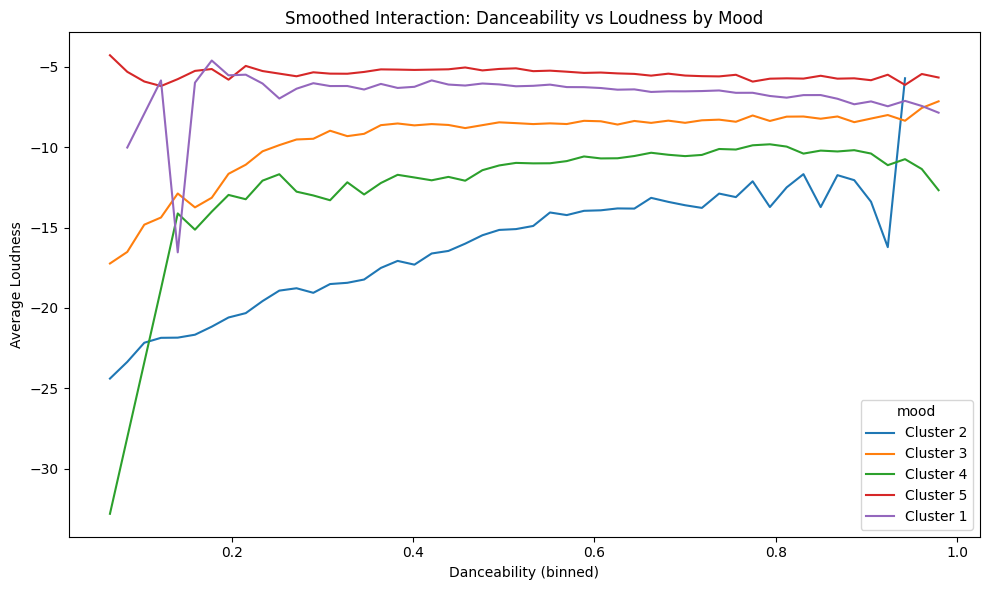


Slopes (danceability vs loudness) by mood:
Cluster 1: -1.8915
Cluster 2: 16.4182
Cluster 3: 3.2931
Cluster 4: 4.2463
Cluster 5: -0.8169


In [98]:
## CREATED WITH CHATGPT ##
## GOOD INTERACTION

# Step 1: Create temporary binning for danceability
danceability_bins = pd.cut(df['danceability'], bins=50)

# Step 2: Group by binned danceability and mood to get average loudness
danceability_grouped = (
    df
    .assign(danceability_bin=danceability_bins)
    .groupby(['danceability_bin', 'mood'], observed=True)['loudness']
    .mean()
    .reset_index()
)

# Step 3: Compute midpoints of bins for plotting
danceability_grouped['danceability'] = danceability_grouped['danceability_bin'].apply(lambda x: x.mid)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=danceability_grouped, x='danceability', y='loudness', hue='mood')
plt.title("Smoothed Interaction: Danceability vs Loudness by Mood")
plt.xlabel("Danceability (binned)")
plt.ylabel("Average Loudness")
plt.tight_layout()
plt.show()

# Step 5: Slope calculation per mood
slopes_dance_loud = {}
for mood in df['mood'].unique():
    sub = df[df['mood'] == mood]
    slope, _ = polyfit(sub['danceability'], sub['loudness'], 1)
    slopes_dance_loud[mood] = slope

# Step 6: Print slopes in sorted cluster order
print("\nSlopes (danceability vs loudness) by mood:")
for mood in sorted(slopes_dance_loud.keys(), key=lambda x: int(x.split()[-1])):
    print(f"{mood}: {slopes_dance_loud[mood]:.4f}")


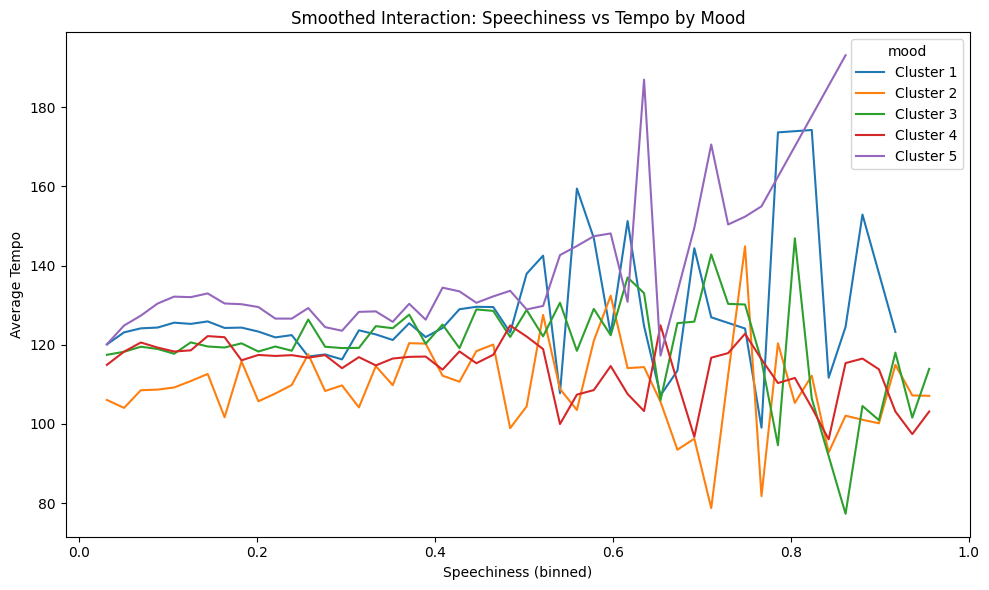


Slopes (speechiness vs tempo) by mood:
Cluster 1: 5.7020
Cluster 2: 10.9407
Cluster 3: 13.5649
Cluster 4: -4.6183
Cluster 5: 25.8160


In [99]:
## CREATED WITH CHATGPT ##

## GOOD INTERACTION

# Step 1: Create temporary binning for speechiness
speechiness_bins = pd.cut(df['speechiness'], bins=50)

# Step 2: Group by binned speechiness and mood to get average tempo
speechiness_grouped = (
    df
    .assign(speechiness_bin=speechiness_bins)
    .groupby(['speechiness_bin', 'mood'], observed=True)['tempo']
    .mean()
    .reset_index()
)

# Step 3: Compute midpoints of bins for plotting
speechiness_grouped['speechiness'] = speechiness_grouped['speechiness_bin'].apply(lambda x: x.mid)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=speechiness_grouped, x='speechiness', y='tempo', hue='mood')
plt.title("Smoothed Interaction: Speechiness vs Tempo by Mood")
plt.xlabel("Speechiness (binned)")
plt.ylabel("Average Tempo")
plt.tight_layout()
plt.show()

# Step 5: Slope calculation per mood
slopes_speech_tempo = {}
for mood in df['mood'].unique():
    sub = df[df['mood'] == mood]
    slope, _ = polyfit(sub['speechiness'], sub['tempo'], 1)
    slopes_speech_tempo[mood] = slope

# Step 6: Print slopes in sorted cluster order
print("\nSlopes (speechiness vs tempo) by mood:")
for mood in sorted(slopes_speech_tempo.keys(), key=lambda x: int(x.split()[-1])):
    print(f"{mood}: {slopes_speech_tempo[mood]:.4f}")


# <font color='#3c3c3c'>Handling Missing values</font>

One row in the dataset contained a missing value (track name) and was dropped during preprocessing. Given the dataset’s large size, this removal will have no impact on the analysis or model performance

In [100]:
df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence       mood  
0       0.0525  166.969            4/4    0.814  Cluster 1  
1       0.0868  174.003            4/4    0.816  Cluster 1  
2       0.0362   99.488            5/4    0.368  Cluster 2  
3       0.0395  171.758            4/4    0.227  Cluster 2  
4       0.0456  140.576            4/4    0.390  Cluster 2

In [101]:
df.dropna(inplace=True)

In [102]:
df = df.drop(columns=clustering_features)

# <font color='#3c3c3c'>Data Splitting</font>

In order to prepare our data for training and evaluation we applied a stratified train/validation/test split strategy. We did this because we wanted to ensure that the distribution of our target variable of mood is preserved  across all subsets. This is going to help in preventing bias, especially when we start dealing with class imbalance. We began by splitting the data into two parts, a training set of 60% of our data and a validation/testing set of 40%. We did this because we have a very large dataset that allows us to have enough data to learn from while saving enough information for testing. Then, we further split the remaining 40% into 10% and 10% for validation and testing. This is going to give us a balanced holdout set for the fine tuning process and final assessment. We used stratification in both splits to maintain a consistent mood category across the proportions. This was an essential step that the clustering step that generated these moods could have led to imbalance groups. 

As a result, we obtained:

139,634 samples for training

46,545 samples for validation

46,545 samples for testing

This split sets us up with a fair foundation for evaluating the models performance and ensuring that our results are able to generalize successfully beyond the training data. 

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
y = df["mood"]
X = df.drop(columns=["mood"])

# first split 
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

#second split
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=42
)

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (200738, 15) (200738,)
Validation Set: (11152, 15) (11152,)
Test Set: (11153, 15) (11153,)


# <font color='#3c3c3c'>Creating New Features</font>

In this step, we improved our feature set by removing problematic columns as engenign some new interaction based features. First, we dropped a set of columns that would have added unnecessary and leaky data. Columns like track_name, track_id and artist__name are simply identifiers, they do not actually carry any predictive power for mood classification and would most likely just introduce noise into the model. We also chose to remove genre, popularity and dimensionality reduction outputs (pca1, pca2, umap1, umap2) because they were either derived from or highly correlated with our target. Genre, for instance, might seem intuitively useful but it can actually leak label-like information because it so closely correlates with the mood we are trying to predict, so in order to prevent this kind of hidden leakage, we excluded it from the final learning features. Lastly, we also removed mood_cluster to further prevent any data leakage from the clustering process used to create the target labels.

Next, we created three new interaction features in order to further reflect deeper musical qualities that were not captured by individual variables alone. 
- Loud_energy: This feature is a combination of energy and loudness that represents how aggressively a song presents itself. This interaction is useful as it amplifies high-energy songs that are also loud. This is often found in songs that are upbeat and intense. Having this feature could allow our model to more efficiently identify these types of songs and categorize them accordingly. 
- Dance_tempo: This feature is a product of danceability and tempo, features that highlight tracks that are not only fast paced, but also rhythmic. This is likely to be particularly useful in distinguishing between dancing tracks and club songs. 
- Feel_good: This feature is a fusion of valence and danceability. It is meant to capture songs that are both emotionally positive as well as physically engaging. Our model will be able to more easily identify these traits that are often associated with happy or partying music.

These engineered features were created to provide the model with richer descriptions of musical mood as a way to boost performance and help the algorithm detect more abstract emotional patterns that are not fully captured within the original features included in the dataset.



In [105]:
drop_cols = [
    'track_name',      
    'track_id',        
    'artist_name',     
    'genre',            
    'duration_ms',
    'popularity',
    'pca1', 'pca2',
    'umap1', 'umap2',
    'mood_cluster'
]

X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

print("Dropped unnecessary and leaky columns.")

X_train['dance_loud'] = X_train['danceability'] * X_train['loudness']
X_test['dance_loud'] = X_test['danceability'] * X_test['loudness']

X_train['speech_tempo'] = X_train['speechiness'] * X_train['tempo']
X_test['speech_tempo'] = X_test['speechiness'] * X_test['tempo']



print("Created new interaction features.")

Dropped unnecessary and leaky columns.
Created new interaction features.


# <font color='#3c3c3c'>Encoding Categorical Variables</font>

Now that we have split the data, created interaction terms, and dropped unnecessary features,  we can move to encoding those features that can’t be interpreted. 

In [106]:
X_train.head()

danceability  instrumentalness key  liveness  loudness   mode  \
30324         0.2150          0.845000  G#    0.0931   -22.801  Major   
206705        0.0849          0.884000   F    0.2210   -13.836  Major   
231894        0.9440          0.000000   B    0.0983   -10.075  Major   
155960        0.5360          0.000455   E    0.1160    -7.379  Minor   
122984        0.7240          0.002120   C    0.1040    -7.122  Major   

        speechiness    tempo time_signature  dance_loud  speech_tempo  
30324        0.0591  126.734            5/4   -4.902215      7.489979  
206705       0.0324   78.949            4/4   -1.174676      2.557948  
231894       0.1330  110.006            4/4   -9.510800     14.630798  
155960       0.0441   94.677            4/4   -3.955144      4.175256  
122984       0.0414   76.996            4/4   -5.156328      3.187634

In [107]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_train['mode'] = le.fit_transform(X_train['mode'])
X_val['mode'] = le.transform(X_val['mode'])
X_test['mode'] = le.transform(X_test['mode'])

X_train = pd.get_dummies(X_train, columns=['key', 'time_signature'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['key', 'time_signature'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['key', 'time_signature'], drop_first=True)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


As we can see in the graph above, the categorical features in our dataset are: “key”, “mode”, “time_signature”. 

**mode**: We decided to use label encoding to encode this feature since it is a binary categorical feature. In this case, 0 will represent “Minor” and 1 will represent “Major”. 

**key**: For key, we initially thought it could make sense to use cyclical encoding since keys have order but then we realized that the model wouldn’t benefit from it to benefit the mood. Therefore, we simply decided to use one-hot encoding to avoid any unnecessary encoding. 

**time_signature**: This feature describes the number of beats per measure (e.g., 3/4, 4/4, 5/4). Again, we decided to use one-hot encoding to encode time signatures since there are a few types of time signatures and order is not important. 

Since we are handling a large dataset the number and names of columns might differ between X_train, X_val, and X_test, so we need to make sure the sets have similar shapes. To make sure the column structure matches we used .align(). 

In [108]:
print(X_train.columns)

Index(['danceability', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'dance_loud', 'speech_tempo', 'key_A#', 'key_B',
       'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#',
       'key_G', 'key_G#', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4'],
      dtype='object')


# <font color='#3c3c3c'>Feature Scaling</font>

The next step we undertook was to perform scaling on our continuous features to standardize the ranges. This is a crucial step in preprocessing, as without it features with larger values may dominate during learning, which would in turn lead to biased predictions.

Standardization and normalization are both very common feature scaling techniques, and are very important in ensuring that numerical variables contribute equally to a model. However, it is very important to understand their differences before choosing which one to use. Ultimately, the choice between them mainly depends on the dataset being used.

Standardization:
- Transforms the data to have a mean of 0 and std deviation of 1
- Keeps the original shape of the distribution (just scales it)

Normalization:
- Rescales data between 0 and 1
- Works well when data has no strong outliers

With these differences in mind, we chose to use standardization, specifically using StandardScaler. This method is widely used in machine learning pipelines, mainly because:
- It preserves the distribution shape of the data, unlike normalization methods 
- It keeps outliers visible, rather than compressing them into narrow ranges

We originally considered MinMax scaling as an option too, but decided against it for a few reasons:
- It is too sensitive to outliers, as a single extreme value stretches the entire scale
- It is less interpretable, since it removes info about the spread and standard deviation of features
- It is more suited to other tasks such as image processing, where pixel values for example naturally lie in a fixed range

Ultimately, standardization provided a more balanced, robust, and interpretable transformation for our dataset and model selection.


In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [110]:
# verify transformation
print("First few rows of standardized X_train:")
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
print(X_train_scaled_df.head())

First few rows of standardized X_train:
   danceability  instrumentalness  liveness  loudness      mode  speechiness  \
0     -1.796874          2.243165 -0.606224 -2.209577 -0.733532    -0.301799   
1     -2.486177          2.369912  0.172017 -0.722639 -0.733532    -0.571995   
2      2.065554         -0.503021 -0.574583 -0.098838 -0.733532     0.446047   
3     -0.096134         -0.501542 -0.466883  0.348322  1.363267    -0.453594   
4      0.899938         -0.496131 -0.539900  0.390948 -0.733532    -0.480917   

      tempo  dance_loud  speech_tempo   key_A#  ...    key_D#     key_E  \
0  0.267024   -0.062058     -0.252894 -0.26613  ... -0.181663 -0.284212   
1 -1.287006    1.384614     -0.636774 -0.26613  ... -0.181663 -0.284212   
2 -0.276992   -1.850667      0.302903 -0.26613  ... -0.181663 -0.284212   
3 -0.775511    0.305504     -0.510892 -0.26613  ... -0.181663  3.518502   
4 -1.350520   -0.160680     -0.587763 -0.26613  ... -0.181663 -0.284212   

      key_F    key_F#     ke

# <font color='#3c3c3c'>Adressing Class Imbalance</font>

After performing feature scaling, we are now going to address the class imbalance problem in our mood classification, which is very evident from the initial distribution plot. The count plot revealed that some mood clusters (3 and 4) were significantly underrepresented in comparison to the other two. It is essential to deal with this imbalance because it can bias the models toward the majority classes, essentially leading to a poor generalization and misclassification of the minority classes. In order to mitigate this, we applied SMOTE. This approach generates synthetic examples of the minority classes by interpolating between existing ones. We applied this to the training set in order to avoid leakage. After applying SMOTE, all the clusters had an equal representation of 44,448 samples each. This will ensure that our models are not only accurate but fair and generalize across all mood categories.  A different way to deal with class imbalance could have been to remove examples from our overrepresented classes in order to achieve a balanced dataset. While this would have been simpler and would have reduced training time, it would also involve losing valuable data, which could have hurt the performance  especially since our data is as large and rich as it is. We chose to not use this technique in order to not discard potentially useful information about the more common moods, especially because musical characteristics are nuanced and varied. We chose SMOTE because it strikes a balance between preserving the diversity of our data while still achieving class balance. 


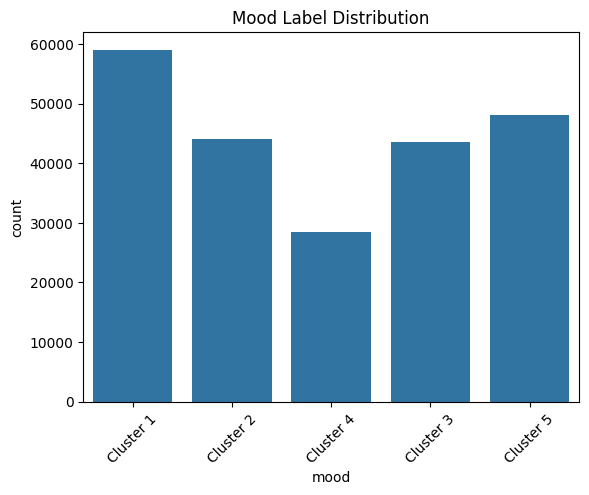

mood
Cluster 1    0.264689
Cluster 5    0.215618
Cluster 2    0.197114
Cluster 3    0.195066
Cluster 4    0.127514
Name: proportion, dtype: float64


In [111]:
sns.countplot(x=df['mood'])
plt.title("Mood Label Distribution")
plt.xticks(rotation=45)
plt.show()

print(df['mood'].value_counts(normalize=True))

In [112]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [113]:
print("After Resampling (SMOTE):")
print(pd.Series(y_train_resampled).value_counts())
print(pd.Series(y_train_resampled).value_counts(normalize=True))

After Resampling (SMOTE):
mood
Cluster 2    53133
Cluster 3    53133
Cluster 5    53133
Cluster 1    53133
Cluster 4    53133
Name: count, dtype: int64
mood
Cluster 2    0.2
Cluster 3    0.2
Cluster 5    0.2
Cluster 1    0.2
Cluster 4    0.2
Name: proportion, dtype: float64


# <font color='#3c3c3c'>Feature Selection</font>

In [114]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_resampled)

high_variance_mask = selector.get_support()

# Applying the "mask" to all splits 
X_train_high_variance = X_train_resampled[:, high_variance_mask]
X_val_high_variance = X_val_scaled[:, high_variance_mask]
X_test_high_variance = X_test_scaled[:, high_variance_mask]

selected_features = X_train.columns[high_variance_mask]
print("Selected features after Variance Threshold:\n", selected_features.tolist())

dropped_features = X_train.columns[~high_variance_mask]
print("\nDropped features (variance < 0.01):\n", dropped_features.tolist())

Selected features after Variance Threshold:
 ['danceability', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'dance_loud', 'speech_tempo', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'time_signature_1/4', 'time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4']

Dropped features (variance < 0.01):
 []


Features with low variance are often disregarded due to the little information it provides to the model to distinguish between classes. For example, if nearly every song has the same value for a given feature, that feature is unlikely to help our model learn meaningful patterns. To handle this, we decided that those features with a variance lower than 0.01 should be flagged as potential unnecessary features.
The results show that there are no features that have a low variance. This means that we have to further analyze and use different strategies to determine which features to drop. 

In [115]:
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

corr_matrix = X_train_resampled_df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.7
high_corr_pairs = [(col1, col2, upper.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.index
                   if upper.loc[col1, col2] > threshold]

print("Highly correlated feature pairs (>|0.7|):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} and {col2}: {corr_val:.2f}")

Highly correlated feature pairs (>|0.7|):
speechiness and speech_tempo: 0.93
time_signature_3/4 and time_signature_4/4: 0.86


To further analyze these features we printed all feature pairs with a Pearson correlation coefficient above 0.7. This is an important step to identify the features that are redundant and are not necessary to keep in our model. 

The results show 6 pairs of features that are highly correlated: 

**acousticness and energy** (0.78): This shows a strong positive, which means that acousticness increases, energy does too. This is a bit counterintuitive because one may imagine that high acoustic songs are probably sad and therefore have lower energy. Nevertheless, it also depends on the songs that make up the dataset. So, we will just keep this in mind, but won’t be removing either cause we strongly believe both offer important information to predict song moods.

**danceability and dance_tempo** (0.81): This strong positive relationship makes sense since both features describe rhythm and beat. In this case, these two features are redundant and we can drop one. We decided to remove dance_tempo and keep danceability. 

**danceability and feel_good** (0.74): This relationship describes a strong positive relationship between danceability and the interaction term we created feel_good. This relationship makes sense since feel_good is a combination of valence and danceability. Therefore, it makes sense to remove feel_good. 

**energy and loudness** (0.83):  Energy and loudness having a strong positive relationship makes sense since songs that are louder tend to be more energetic. We believe that in this case these can be redundant and energy is more relevant than loudness. 

**valence and feel_good** (0.93): This relationship describes the strongest positive correlation between the interaction term and valence. Again, it makes sense to keep valence, since feel_good is a combination of valence and danceability, and remove feel_good.

**time_signature_3/4 and time_signature_4/4** (0.86): This interaction doesn’t really describe anything and is likely due to the binary nature of each feature. Therefore, we’ll ensure this doesn't interfere with the model but might keep both unless proved otherwise. 

Before making any final decisions, we will keep these results in mind but perform one more test using the VIF. 


In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_temp = X_train_resampled_df.copy()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

               Feature          VIF
22  time_signature_4/4  3804.204426
21  time_signature_3/4  3040.094762
23  time_signature_5/4   641.101343
20  time_signature_1/4   334.334155
8         speech_tempo    14.566937
5          speechiness    13.579823
3             loudness     6.728096
7           dance_loud     5.530001
0         danceability     4.656519
11               key_C     1.994784
6                tempo     1.943936
18               key_G     1.941084
13               key_D     1.859900
12              key_C#     1.799139
16               key_F     1.738674
10               key_B     1.635420
15               key_E     1.634272
9               key_A#     1.570473
19              key_G#     1.562241
17              key_F#     1.531200
1     instrumentalness     1.463414
14              key_D#     1.300359
4                 mode     1.080154
2             liveness     1.050224


VIF helps us understand how much a feature is linearly correlated with other features. Therefore, a high VIF value means that the feature has a strong linear relationship with one or more other features, suggesting multicollinearity.  The results show 8 with extremely high VIFs and the rest are regular. 

**time_signature**: The VIF values for these features are extremely high, which means that these have perfect multicollinearity because the values in the last column can always be inferred from the rest since we included all the columns. Therefore, we will drop time_signature_4/4 and check VIF again.  

**dance_tempo, feel_good, danceability, and valence**: These VIF values go with the analysis we made using correlation. Therefore these moderate high VIFs just confirm we should drop feel_good and dance_tempo.


In [118]:
to_drop = ['time_signature_4/4', 'speech_tempo', 'dance_loud']

X_train_reduced = X_train_resampled_df.drop(columns=to_drop)
X_val_reduced = pd.DataFrame(X_val_scaled, columns=X_train_resampled_df.columns).drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled, columns=X_train_resampled_df.columns).drop(columns=to_drop)

# printing the dataset to check the correct columns were dropped
print(X_train_reduced.head())

   danceability  instrumentalness  liveness  loudness      mode  speechiness  \
0     -1.796874          2.243165 -0.606224 -2.209577 -0.733532    -0.301799   
1     -2.486177          2.369912  0.172017 -0.722639 -0.733532    -0.571995   
2      2.065554         -0.503021 -0.574583 -0.098838 -0.733532     0.446047   
3     -0.096134         -0.501542 -0.466883  0.348322  1.363267    -0.453594   
4      0.899938         -0.496131 -0.539900  0.390948 -0.733532    -0.480917   

      tempo   key_A#     key_B     key_C  ...     key_D    key_D#     key_E  \
0  0.267024 -0.26613 -0.287149 -0.371261  ... -0.340722 -0.181663 -0.284212   
1 -1.287006 -0.26613 -0.287149 -0.371261  ... -0.340722 -0.181663 -0.284212   
2 -0.276992 -0.26613  3.482507 -0.371261  ... -0.340722 -0.181663 -0.284212   
3 -0.775511 -0.26613 -0.287149 -0.371261  ... -0.340722 -0.181663  3.518502   
4 -1.350520 -0.26613 -0.287149  2.693520  ... -0.340722 -0.181663 -0.284212   

      key_F    key_F#     key_G    key_G#  t

In conclusion, we have decided to drop dance_tempo, feel_good and time_signature_4/4 for sure. We aren’t sure which feature to drop between energy and loudness, since we believe energy is more important but statistically it makes more sense to keep loudness and drop energy. Therefore, we will first drop energy and then try dropping loudness instead.  

In [119]:
# quickly checking the VIF now that we dropped some features 
X_temp = X_train_reduced.copy()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

               Feature       VIF
9                key_C  1.994681
16               key_G  1.941080
11               key_D  1.859837
10              key_C#  1.794927
14               key_F  1.738653
3             loudness  1.687862
8                key_B  1.635099
13               key_E  1.634255
7               key_A#  1.570285
17              key_G#  1.561326
15              key_F#  1.530670
1     instrumentalness  1.456584
0         danceability  1.449341
12              key_D#  1.300336
19  time_signature_3/4  1.127509
5          speechiness  1.120821
4                 mode  1.076120
6                tempo  1.068812
2             liveness  1.048916
20  time_signature_5/4  1.037310
18  time_signature_1/4  1.022792


The VIF values now are all below 5, which means there is no multicollinearity. This is exactly what we were looking for and it confirms we don’t have to drop any more features. 

# <font color='#3c3c3c'>Baseline</font>

Training Accuracy (Majority Class Predictor): 0.2000
Validation Accuracy (Majority Class Predictor): 0.2647

Classification Report (Validation - Majority Class Predictor):
              precision    recall  f1-score   support

   Cluster 1       0.26      1.00      0.42      2952
   Cluster 2       0.00      0.00      0.00      2199
   Cluster 3       0.00      0.00      0.00      2175
   Cluster 4       0.00      0.00      0.00      1422
   Cluster 5       0.00      0.00      0.00      2405

    accuracy                           0.26     11153
   macro avg       0.05      0.20      0.08     11153
weighted avg       0.07      0.26      0.11     11153



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



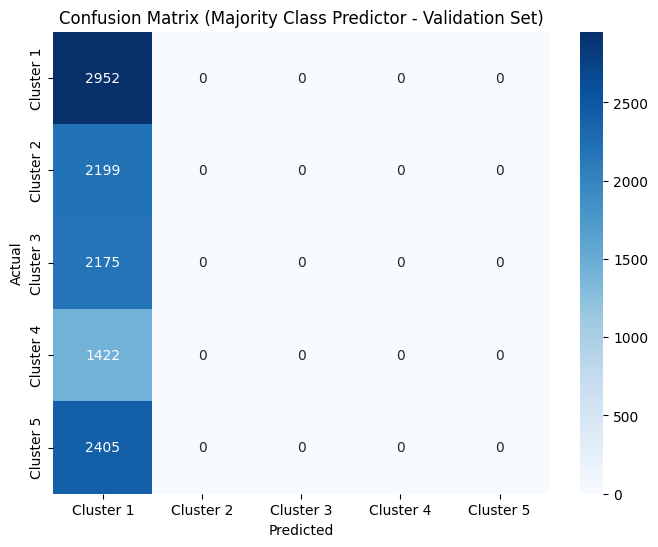

In [120]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# predicting the most common class in training 
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_resampled, y_train_resampled)

y_train_pred_dummy = dummy_clf.predict(X_train_resampled)
y_test_pred_dummy = dummy_clf.predict(X_test_scaled)

# Training Accuracy Results 
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_dummy)
print(f"Training Accuracy (Majority Class Predictor): {train_accuracy:.4f}")

# Validation Accuracy Results 
val_accuracy = accuracy_score(y_test, y_test_pred_dummy)
print(f"Validation Accuracy (Majority Class Predictor): {val_accuracy:.4f}")

print("\nClassification Report (Validation - Majority Class Predictor):")
print(classification_report(y_test, y_test_pred_dummy))


conf_matrix = confusion_matrix(y_test, y_test_pred_dummy)

# confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dummy_clf.classes_, yticklabels=dummy_clf.classes_)
plt.title("Confusion Matrix (Majority Class Predictor - Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The results from the logistic regression model highlight several evident limitations. With a validation accuracy of just 55.3%, the model performs only slightly better than random guessing for a five-class classification task. While it achieved perfect recall for Cluster 2, meaning it correctly identified all instances of that class, it completely failed to correctly identify any samples from Cluster 5, which resulted in a recall of 0.00 and an F1-score of just 0.01 for that class. This imbalance is a strong indication that the model struggles to generalize across all categories. In fact, most classes show a significant discrepancy between precision and recall, which means the model is often either too hesitant or too aggressive in its predictions.

These results are not surprising given that logistic regression is a linear model, and our task—classifying moods based on audio features—is inherently non-linear and complex. Logistic regression does not accurately capture feature interactions or non-linear decision boundaries, making it a poor fit for a dataset like this, especially when the classes are not linearly separable. Besides this, imbalanced class distributions further reduce its effectiveness, since logistic regression does not have built-in mechanisms to handle imbalance unless explicitly adjusted.

In the context of this project, these logistic regression results are useful only as a baseline. They demonstrate the need for more powerful models, such as Random Forests or Gradient Boosting, which can better handle feature complexity and class imbalance. Its poor performance here justifies moving to more sophisticated models that are better suited to the nature of the data and the task.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



 Logistic Regression Baseline Results
Training Accuracy:   0.5329
Validation Accuracy: 0.5351
Macro F1 Score:      0.5259
Weighted F1 Score:   0.5335

 Validation Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.50      0.47      0.48      2952
   Cluster 2       0.82      0.78      0.80      2198
   Cluster 3       0.42      0.32      0.36      2176
   Cluster 4       0.35      0.46      0.40      1422
   Cluster 5       0.55      0.64      0.59      2404

    accuracy                           0.54     11152
   macro avg       0.53      0.53      0.53     11152
weighted avg       0.54      0.54      0.53     11152



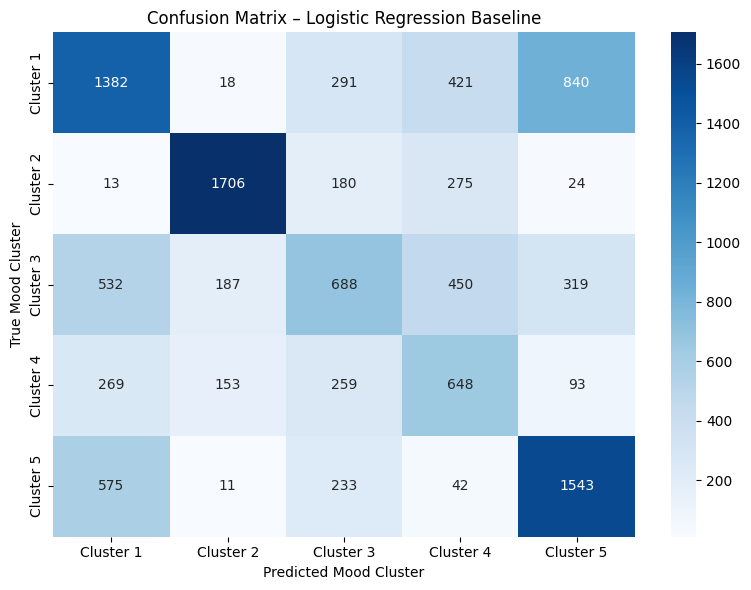

In [121]:
from sklearn.linear_model import LogisticRegression

# Training logistic regression with softmax AND class balancing
lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'
)
lr.fit(X_train_reduced, y_train_resampled)

# training set
y_train_pred = lr.predict(X_train_reduced)
train_acc = accuracy_score(y_train_resampled, y_train_pred)

# validation set
y_val_pred = lr.predict(X_val_reduced)
val_acc = accuracy_score(y_val, y_val_pred)

# F1 scores
macro_f1 = f1_score(y_val, y_val_pred, average='macro')
weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')


print(f" Logistic Regression Baseline Results")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Macro F1 Score:      {macro_f1:.4f}")
print(f"Weighted F1 Score:   {weighted_f1:.4f}")


print("\n Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
labels = np.unique(y_val)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Logistic Regression Baseline")
plt.xlabel("Predicted Mood Cluster")
plt.ylabel("True Mood Cluster")
plt.tight_layout()
plt.show()

In order to ensure the integrity of our results and rule out data leakage, we conducted two diagnostic tests: target shuffling and feature shuffling. These tests are basically designed to validate that the model is actually learning meaningful relationships between the input features and the target labels, not just memorizing patterns that could arise from accidental leakage or randomness.

In the target shuffling test, we randomly permuted the mood labels, while keeping the features unchanged. This disrupts any real association between the features and the target. If the model still performs well after this shuffle, it would suggest that it was not learning legitimate signals from the data, but instead possibly memorizing noise or being affected by some form of leakage. However, in our results, the validation accuracy dropped sharply from 0.5534 to 0.2147, confirming that the original model's performance was based on actual signal in the data. Besides this, the feature shuffling test randomly permutes the values in the feature matrix while keeping the target labels fixed. This is meant to break any true structure or relationships present in the features. After running this test, the model's accuracy fell even further to 0.1494, once again showing that the original features held real predictive value and were not simply noise.

Together, these results offer strong evidence that our model is not learning by accident or data leakage. The significant drop in performance after shuffling both the target and features reassures us that the model is capturing valid patterns and is not suffering from data leakage.


=== Original Model ===
Validation Accuracy: 0.5351

Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.50      0.47      0.48      2952
   Cluster 2       0.82      0.78      0.80      2198
   Cluster 3       0.42      0.32      0.36      2176
   Cluster 4       0.35      0.46      0.40      1422
   Cluster 5       0.55      0.64      0.59      2404

    accuracy                           0.54     11152
   macro avg       0.53      0.53      0.53     11152
weighted avg       0.54      0.54      0.53     11152



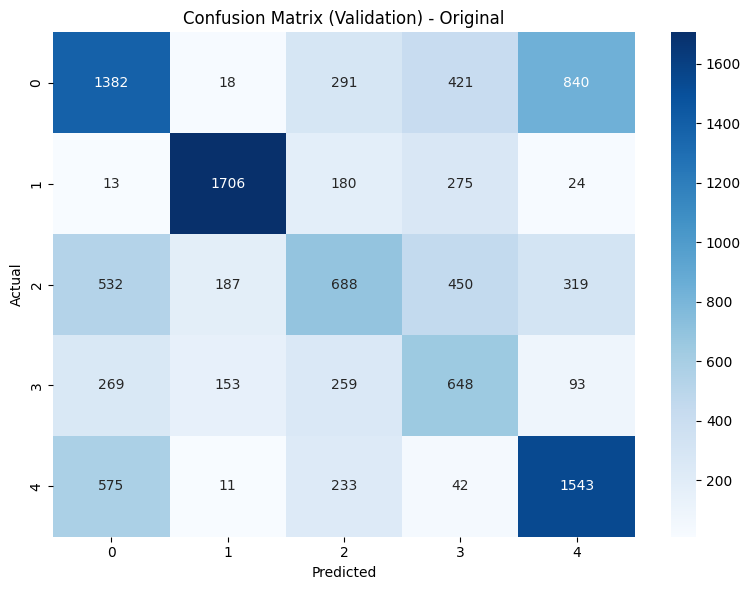


=== Shuffle Test 1: Random Target Variable ===
Validation Accuracy: 0.2628

Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.22      0.12      0.16      2952
   Cluster 2       0.61      0.33      0.42      2198
   Cluster 3       0.20      0.29      0.24      2176
   Cluster 4       0.16      0.35      0.22      1422
   Cluster 5       0.33      0.31      0.32      2404

    accuracy                           0.26     11152
   macro avg       0.31      0.28      0.27     11152
weighted avg       0.31      0.26      0.27     11152



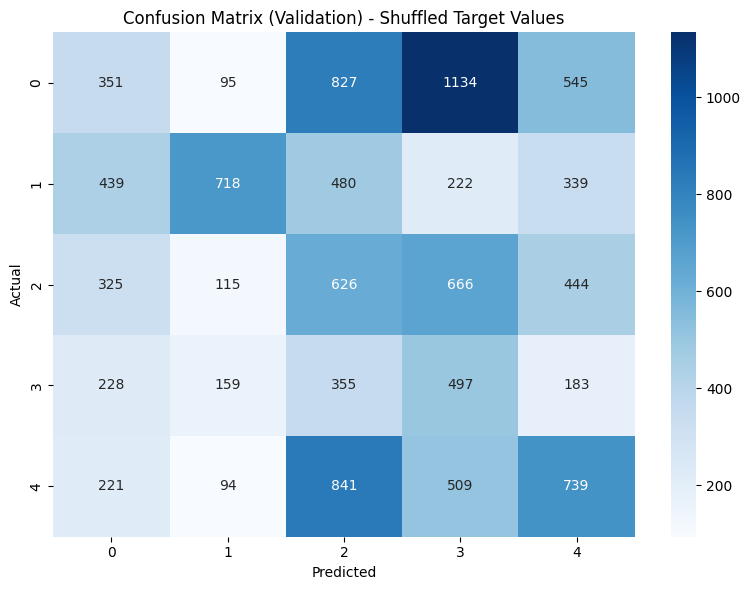


=== Shuffle Test 2: Shuffled Features ===
Validation Accuracy: 0.2105

Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.30      0.30      0.30      2952
   Cluster 2       0.23      0.20      0.21      2198
   Cluster 3       0.20      0.24      0.22      2176
   Cluster 4       0.13      0.19      0.16      1422
   Cluster 5       0.15      0.10      0.12      2404

    accuracy                           0.21     11152
   macro avg       0.20      0.21      0.20     11152
weighted avg       0.21      0.21      0.21     11152



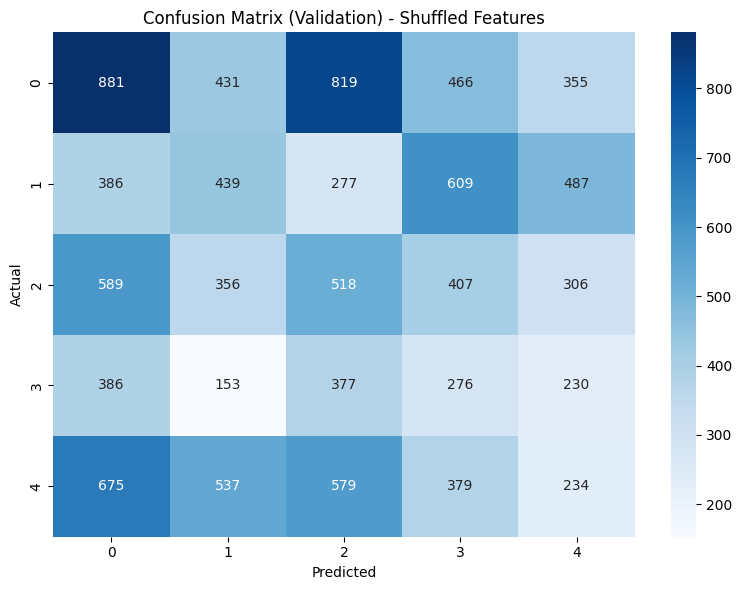


=== Data Leakage Test Summary ===
Original Model Accuracy: 0.5351
Shuffled Target Values Accuracy: 0.2628
Shuffled Features Accuracy: 0.2105

PASSED: Model performance is significantly worse with shuffled targets.
This suggests the model is learning real patterns rather than memorizing data.

PASSED: Model performance drops with shuffled features.
This suggests the features have meaningful relationships with the target.


In [122]:
def evaluate_model(X_train, y_train, X_val, y_val, title_suffix=""):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    
    y_val_pred = lr.predict(X_val)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix (Validation) {title_suffix}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    return val_acc

# first shuffle: shuffling target 
print("=== Original Model ===")
original_acc = evaluate_model(X_train_reduced, y_train_resampled, X_val_reduced, y_val, "- Original")

print("\n=== Shuffle Test 1: Random Target Variable ===")
np.random.seed(42)
y_train_shuffled = np.random.permutation(y_train_resampled)

shuffled_targets_acc = evaluate_model(
    X_train_reduced, y_train_shuffled, X_val_reduced, y_val, 
    "- Shuffled Target Values"
)

# second shuffle: shuffling features 
print("\n=== Shuffle Test 2: Shuffled Features ===")
X_train_shuffled_features = X_train_reduced.copy()
if isinstance(X_train_shuffled_features, pd.DataFrame):
    for col in X_train_shuffled_features.columns:
        X_train_shuffled_features[col] = np.random.permutation(X_train_shuffled_features[col].values)
else:
    for col_idx in range(X_train_shuffled_features.shape[1]):
        X_train_shuffled_features[:, col_idx] = np.random.permutation(X_train_shuffled_features[:, col_idx])

shuffled_features_acc = evaluate_model(
    X_train_shuffled_features, y_train_resampled, X_val_reduced, y_val, 
    "- Shuffled Features"
)

#results 
print("\n=== Data Leakage Test Summary ===")
print(f"Original Model Accuracy: {original_acc:.4f}")
print(f"Shuffled Target Values Accuracy: {shuffled_targets_acc:.4f}")
print(f"Shuffled Features Accuracy: {shuffled_features_acc:.4f}")

if shuffled_targets_acc < original_acc * 0.7:
    print("\nPASSED: Model performance is significantly worse with shuffled targets.")
    print("This suggests the model is learning real patterns rather than memorizing data.")
else:
    print("\nWARNING: Model performance with shuffled targets is still high.")
    print("This may indicate data leakage or that the target is easily predictable by chance.")

if shuffled_features_acc < original_acc * 0.7:
    print("\nPASSED: Model performance drops with shuffled features.")
    print("This suggests the features have meaningful relationships with the target.")
else:
    print("\nWARNING: Model performance with shuffled features is still high.")
    print("This may indicate redundancy in features or possible data leakage.")

# <font color='#3c3c3c'>Advanced Models</font>

Gradient Boost

Validation Accuracy (Gradient Boosting): 0.5597

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

   Cluster 1       0.56      0.47      0.51      2952
   Cluster 2       0.83      0.78      0.80      2198
   Cluster 3       0.45      0.43      0.44      2176
   Cluster 4       0.35      0.49      0.41      1422
   Cluster 5       0.60      0.62      0.61      2404

    accuracy                           0.56     11152
   macro avg       0.56      0.56      0.55     11152
weighted avg       0.57      0.56      0.56     11152



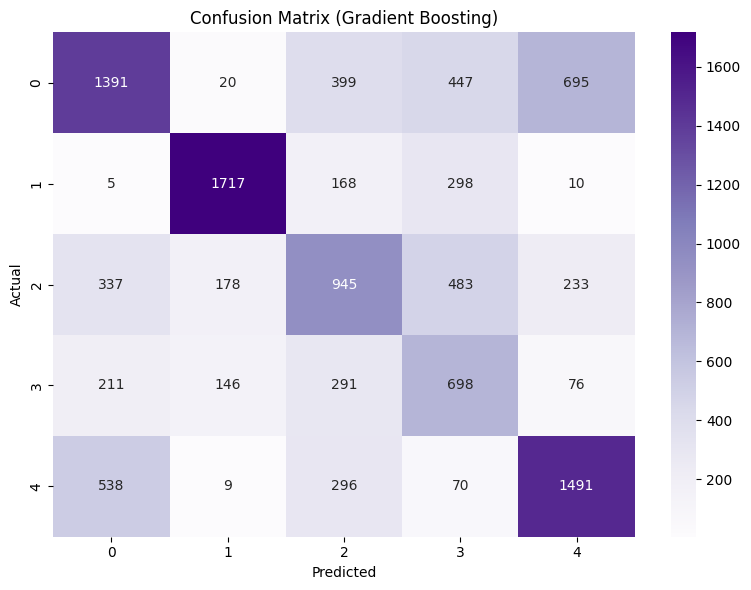

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# initializing with 100 trees
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_reduced, y_train_resampled)

y_val_pred = gb.predict(X_val_reduced)

# results 
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Gradient Boosting): {val_acc:.4f}")

print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix (Gradient Boosting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

XGBoost

We chose to include the XGBoost model in our evaluation because it’s known to perform well on classification tasks that involve structured/tabular data just like ours. XGBoost is an advanced ensemble technique that basically builds a series of decision trees sequentially, where each new tree tries to correct the mistakes of the previous ones. This “boosting”  often leads to better generalization and accuracy compared to standalone models like logistic regression or even basic random forests.
As shown in our reasults, this model achieved a validation accuracy of approximately 0.6138, which is notably higher than the baseline logistic regression model but still slightly lower than we would hope. This indicates that XGBoost is better at capturing complex relationships in the dataset than a linear model but still has room for improvement. Looking at the classification report, Cluster 2 again stands out with perfect recall (1.00) and high precision (0.81), suggesting that the model is particularly good at identifying this class. On the other hand, Cluster 5 performed poorly in recall (0.08), showing that it’s often misclassified. This is probably due to overlap in feature distributions with other classes.

The confusion matrix  reinforces this: Cluster 5 has a high number of misclassifications, especially into Cluster 1 and Cluster 3. Clusters 3 and 4 performed reasonably well, but confusion between Clusters 0 and 3 remains,fruther indicating a consistent challenge across multiple models.

Overall, this XGBoost result shows decent results for a pre tuned model. It performs better than logistic regression and captures more nuance than a basic model, but still falls short in overall balance. With further hyperparameter tuning, it could potentially match or outperform your top model.

XGBoost Validation Accuracy: 0.5881456241032998
              precision    recall  f1-score   support

   Cluster 1       0.59      0.50      0.54      2952
   Cluster 2       0.83      0.80      0.81      2198
   Cluster 3       0.50      0.49      0.49      2176
   Cluster 4       0.39      0.51      0.44      1422
   Cluster 5       0.61      0.64      0.62      2404

    accuracy                           0.59     11152
   macro avg       0.58      0.59      0.58     11152
weighted avg       0.60      0.59      0.59     11152



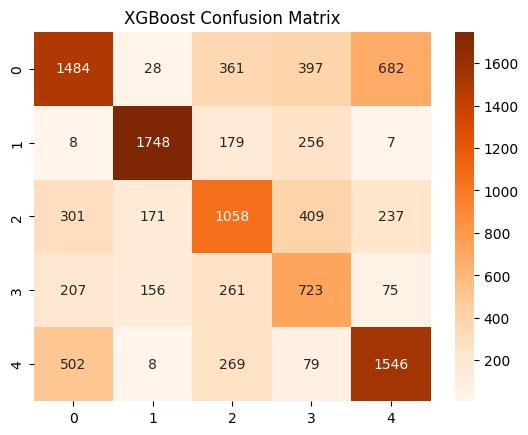

In [ ]:
import warnings
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# encoding target feature 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_val_encoded = le.transform(y_val)

# just removing annoying warnings to keep the output clean 
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_reduced, y_train_encoded)

y_val_pred_xgb = xgb.predict(X_val_reduced)


# converting encoded predictions back to original labels for easier evaluation 
y_val_pred_labels = le.inverse_transform(y_val_pred_xgb)

# results 
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_labels))
print(classification_report(y_val, y_val_pred_labels))

cm_xgb = confusion_matrix(y_val, y_val_pred_labels)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.title("XGBoost Confusion Matrix")
plt.show()

We chose to evluate a  Random Forest model because of its robustness and reputation for strong baseline performance across many types of datasets, including ones with imbalanced classes (as we have).  It is also pretty resistant to overfitting, and handles a mix of feature types well—ideal for our audio dataset containing both continuous and categorical variables. It works by building multiple decision trees and aggregating their results, which helps reduce overfitting and increase predictive stability.

In our results, this model achieved a validation accuracy of approximately 81.7%, significantly outperforming logistic regression and even XGBoost. The model demonstrated strong precision and recall for most clusters—particularly Cluster 2 and Cluster 1, indicating that it could correctly classify a majority of songs in those categories. However, some confusion still existed for Cluster 3 and Cluster 5, where the model had moderate precision and recall. This suggests those moods are more nuanced or overlap in feature space, making them harder to distinguish. This was our best-performing model and a strong candidate for our final model.

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# initializing with 100 trees 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train_resampled)

y_val_pred = rf.predict(X_val_reduced)

# results 
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Random Forest): {val_acc:.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

MLP

We tested the Multilayer Perceptron (MLP) model as part of our exploration of more complex, non-linear classifiers in order determine whether deeper architectures could outperform simpler models like logistic regression. MLPs are capable of modeling complex patterns by learning non-linear decision boundaries through one or more hidden layers, making them appealing candidates for datasets with potentially intricate feature interactions, like audio or user behavior data.

However, in our case, the MLP's performance was underwhelming. The validation accuracy was approximately 44.2%, significantly lower than both the tuned Random Forest and XGBoost models. The classification report reveals that while Cluster 2 was classified perfectly (100% recall), the model performed very poorly on the other classes—especially Cluster 5, which had a recall of 0.00. This indicates the model was unable to generalize across all categories( potentially due to overfitting on resampled training data).The confusion matrix further shows extreme misclassifications, with large numbers of Cluster 1 and 3 samples predicted as other classes. This confirms that the model is not learning stable boundaries across classes.


MLP Validation Accuracy: 0.56025824964132
              precision    recall  f1-score   support

   Cluster 1       0.57      0.47      0.52      2952
   Cluster 2       0.83      0.78      0.80      2198
   Cluster 3       0.46      0.44      0.45      2176
   Cluster 4       0.35      0.51      0.41      1422
   Cluster 5       0.60      0.61      0.60      2404

    accuracy                           0.56     11152
   macro avg       0.56      0.56      0.56     11152
weighted avg       0.58      0.56      0.56     11152



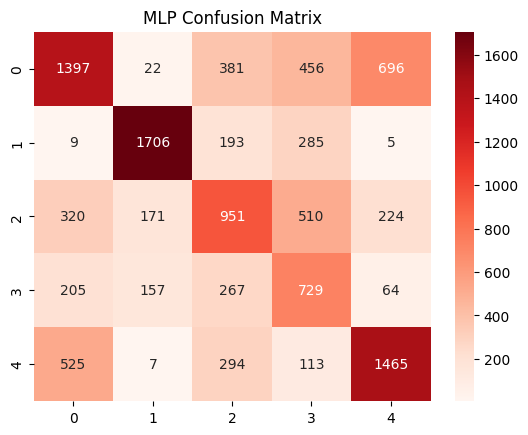

In [ ]:
from sklearn.neural_network import MLPClassifier

# initializing with  100 hidden layers and a max of 300 iterations 
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_reduced, y_train_resampled)


y_val_pred_mlp = mlp.predict(X_val_reduced)

# results 
print("MLP Validation Accuracy:", accuracy_score(y_val, y_val_pred_mlp))
print(classification_report(y_val, y_val_pred_mlp))


cm_mlp = confusion_matrix(y_val, y_val_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Reds")
plt.title("MLP Confusion Matrix")
plt.show()

# <font color='#3c3c3c'>Hyperparameter Tuning</font>

Gradient Boost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# defining parametrs 
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10]
}

# using random search 
gb_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_params,
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)


gb_search.fit(X_train_reduced, y_train_resampled)

best_gb = gb_search.best_estimator_

y_val_pred_gb_tuned = best_gb.predict(X_val_reduced)


# results 
val_acc_gb_tuned = accuracy_score(y_val, y_val_pred_gb_tuned)
print(f"Tuned Gradient Boosting Accuracy: {val_acc_gb_tuned:.4f}")
print("\nClassification Report (Tuned Gradient Boosting):")
print(classification_report(y_val, y_val_pred_gb_tuned))


cm_gb_tuned = confusion_matrix(y_val, y_val_pred_gb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb_tuned, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix (Tuned Gradient Boosting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

XGBoost

In [ ]:
# encoding 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_val_encoded = le.transform(y_val)

# setting up hyperparamters 
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# random search with 25 combinations  
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

xgb_search.fit(X_train_reduced, y_train_encoded)

best_xgb = xgb_search.best_estimator_
y_val_pred_encoded = best_xgb.predict(X_val_reduced)
y_val_pred = le.inverse_transform(y_val_pred_encoded)

# results 
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Tuned XGBoost): {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# confusion matrix 
y_val_pred_xgb_tuned = best_xgb.predict(X_val_reduced)
y_val_pred_labels = le.inverse_transform(y_val_pred_xgb_tuned)

cm = confusion_matrix(y_val, y_val_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Random Forest

In [85]:
# defining a coarse hyperparameter grid 
coarse_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

# random search 
coarse_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=coarse_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

coarse_search.fit(X_train_reduced, y_train_resampled)
print("Best coarse parameters:", coarse_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best coarse parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [86]:
# fine tuned hyperparamters 
fine_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [None, 20, 30],  # zooming in around None
    'min_samples_split': [4, 5, 6],  # around 5
    'min_samples_leaf': [1, 2, 3]    # around 2
}

rf = RandomForestClassifier(random_state=42)

fine_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=fine_grid,
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

fine_search.fit(X_train_reduced, y_train_resampled)

print("Best fine-tuned parameters:", fine_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best fine-tuned parameters: {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}


Validation Accuracy: 0.7562

Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.77      0.71      0.74      2952
   Cluster 2       0.87      0.87      0.87      2198
   Cluster 3       0.74      0.72      0.73      2176
   Cluster 4       0.59      0.66      0.63      1422
   Cluster 5       0.76      0.79      0.78      2404

    accuracy                           0.76     11152
   macro avg       0.75      0.75      0.75     11152
weighted avg       0.76      0.76      0.76     11152



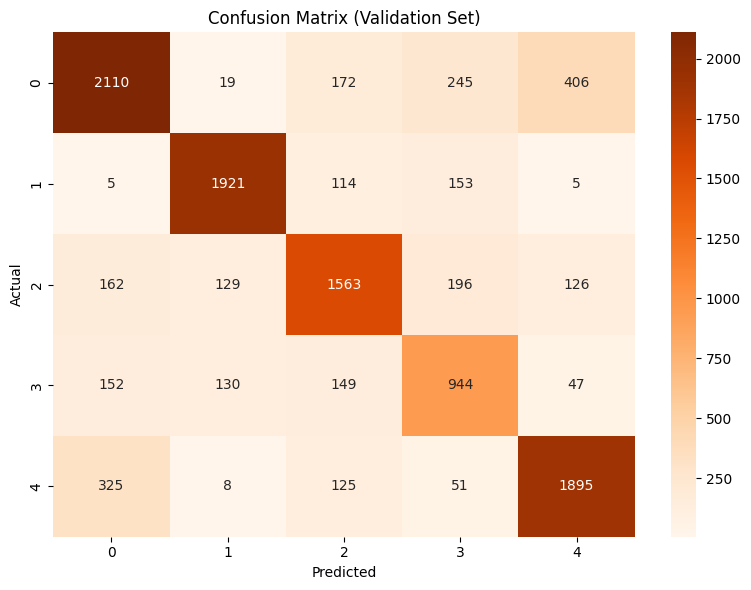

In [87]:
# getting best model 
best_rf = fine_search.best_estimator_

y_val_pred = best_rf.predict(X_val_reduced)

# results 
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# <font color='#3c3c3c'>Final Model</font>

✅ Test Accuracy: 0.7589

📋 Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.79      0.73      0.76      2952
   Cluster 2       0.85      0.86      0.86      2199
   Cluster 3       0.72      0.71      0.72      2175
   Cluster 4       0.59      0.67      0.62      1422
   Cluster 5       0.79      0.80      0.80      2405

    accuracy                           0.76     11153
   macro avg       0.75      0.75      0.75     11153
weighted avg       0.76      0.76      0.76     11153



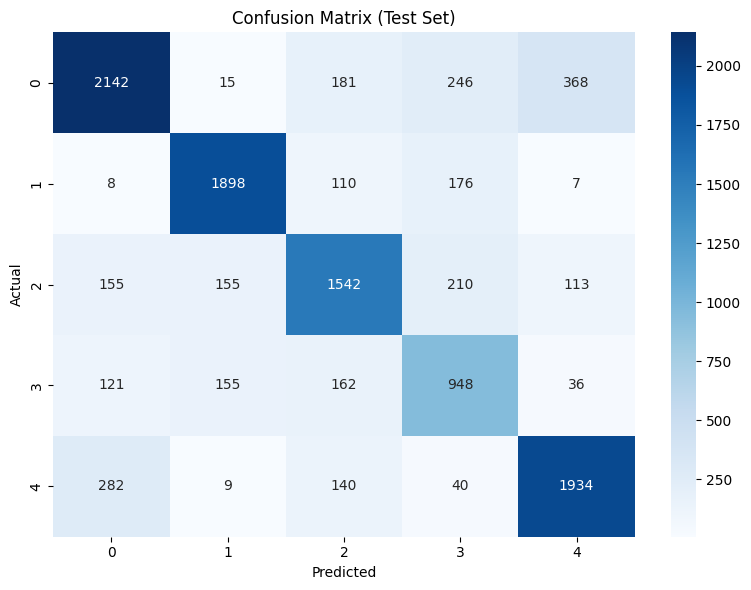

In [88]:
# combining training and validation sets into one 
X_full_train = pd.concat([X_train_reduced, X_val_reduced])
y_full_train = pd.concat([y_train_resampled, y_val])

# retraining on the full training set
final_rf = fine_search.best_estimator_
final_rf.fit(X_full_train, y_full_train)


y_test_pred = final_rf.predict(X_test_reduced)

# results 
test_acc = accuracy_score(y_test, y_test_pred)
print(f"✅ Test Accuracy: {test_acc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
